<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminary" data-toc-modified-id="Preliminary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminary</a></span></li><li><span><a href="#Case-Study" data-toc-modified-id="Case-Study-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Case Study</a></span><ul class="toc-item"><li><span><a href="#Case-1" data-toc-modified-id="Case-1-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Case 1</a></span></li><li><span><a href="#Case-2" data-toc-modified-id="Case-2-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Case 2</a></span></li></ul></li></ul></div>

In [184]:
import os
import string
import torch
from torch import nn
from torch.nn import functional as F
if not "CHDIR_FLAG" in dir():
    os.chdir("../")
    CHDIR_FLAG = True
    
import numpy as np
import pandas as pd
from datasets import load_dataset

from src.tools.torch import register_forward_hook_decorator, register_backward_hook_decorator
from transformers import AutoTokenizer, AutoModelForCausalLM

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Preliminary

这边使用的是`src.tools.transformers`中手写的解码方法，在`model.forward`外面套了个hook装饰器（定义在`src.tools.hook`中）

目的是挖掘不同输入带了的各隐层输入输出的变化

In [198]:
def easy_compare_forward_hook_data(
    hook_data_path_1, 
    hook_data_path_2,
    forward_hook_module_names,
):
    hook_data_1 = torch.load(hook_data_path_1)
    hook_data_2 = torch.load(hook_data_path_2)
    # print(f"# Hook Data 1: {len(hook_data_1)}")
    # print(f"# Hook Data 1: {len(hook_data_2)}")
    for i, (data_1, data_2) in enumerate(zip(hook_data_1, hook_data_2)):
        if i > 0:
            # Care about the first generated token only
            break
        diff_dict = {
            # "embed_tokens": {"input": [], "output": []},
            # "norm": {"input": [], "output": []},
            "q_proj": {"input": [], "output": []},
            "k_proj": {"input": [], "output": []},
            "v_proj": {"input": [], "output": []},
        }
        for module_name in forward_hook_module_names:
            module_name_suffix = module_name.split('.')[-1]
            if module_name_suffix in diff_dict:
                input_data_1 = data_1[module_name]["input"]
                input_data_2 = data_2[module_name]["input"]
                output_data_1 = data_1[module_name]["output"]
                output_data_2 = data_2[module_name]["output"]      
                # Assertation for ensuring data format
                assert isinstance(input_data_1, list) and len(input_data_1) == 1 and isinstance(input_data_1[0], tuple) and len(input_data_1[0]) == 1
                assert isinstance(input_data_2, list) and len(input_data_2) == 1 and isinstance(input_data_2[0], tuple) and len(input_data_2[0]) == 1
                assert isinstance(output_data_1, list) and len(output_data_1) == 1 and isinstance(output_data_1[0], torch.Tensor)
                assert isinstance(output_data_2, list) and len(output_data_2) == 1 and isinstance(output_data_2[0], torch.Tensor)
                input_diff = torch.norm(input_data_1[0][0].float() - input_data_2[0][0].float(), p="fro")
                output_diff = torch.norm(output_data_1[0] - output_data_2[0], p="fro")
                avg_input_diff = input_diff / input_data_1[0][0].numel()
                avg_output_diff = output_diff / output_data_1[0].numel()
                log_input_diff = torch.log(avg_input_diff)
                log_output_diff = torch.log(avg_output_diff)
                diff_dict[module_name_suffix]["input"].append(avg_input_diff.item())
                diff_dict[module_name_suffix]["output"].append(avg_output_diff.item())
        
        if len(diff_dict) == 3:
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))
            for i, key in enumerate(diff_dict):
                y_input = diff_dict[key]["input"]
                y_output = diff_dict[key]["output"]
                assert len(y_input) == len(y_output)
                x = range(len(y_input))
                if len(x) == 0:
                    continue
                axs[i].bar(x, y_input, label="input_diff", alpha=.5)
                axs[i].bar(x, y_output, label="output_diff", alpha=.5)
                axs[i].set_xlabel("Layer #"), axs[i].set_ylabel("Diff"), axs[i].set_title(f"Diff for {key}")
            plt.legend(), plt.show(), plt.close()

# Case Study

## Case 1

针对两个简单的案例进行对比分析：

- `strawberry-1`: 英文单词strawberry中有几个字母s？
- `strawberry-2`: 英文单词strawberry中有几个字母r？

In [156]:
forward_hook_module_names = \
    [f"model.layers[{i}].self_attn.q_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.k_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.v_proj" for i in range(24)]

hook_data_path_1_1 = r"./results/strawberry-1/fhook+Qwen2.5-0.5B-Instruct+False.pt"
hook_data_path_1_2 = r"./results/strawberry-1/fhook+Qwen2.5-0.5B-Instruct+True.pt"
hook_data_path_2_1 = r"./results/strawberry-2/fhook+Qwen2.5-0.5B-Instruct+False.pt"
hook_data_path_2_2 = r"./results/strawberry-2/fhook+Qwen2.5-0.5B-Instruct+True.pt"

table_path_1_1 = r"./results/strawberry-1/decode+Qwen2.5-0.5B-Instruct+False.csv"
table_path_1_2 = r"./results/strawberry-1/decode+Qwen2.5-0.5B-Instruct+True.csv"
table_path_2_1 = r"./results/strawberry-2/decode+Qwen2.5-0.5B-Instruct+False.csv"
table_path_2_2 = r"./results/strawberry-2/decode+Qwen2.5-0.5B-Instruct+True.csv"

# Hook Data 1: 32
# Hook Data 1: 32


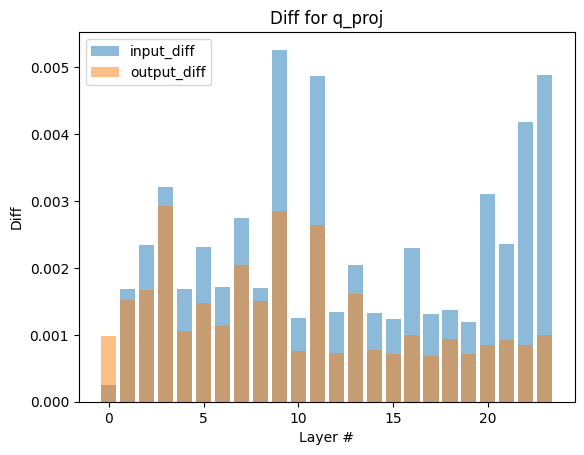

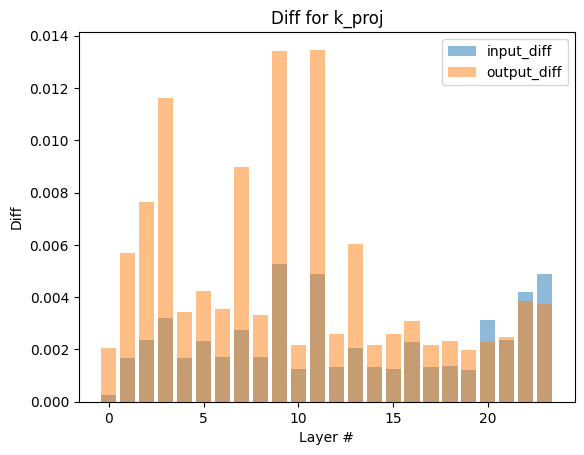

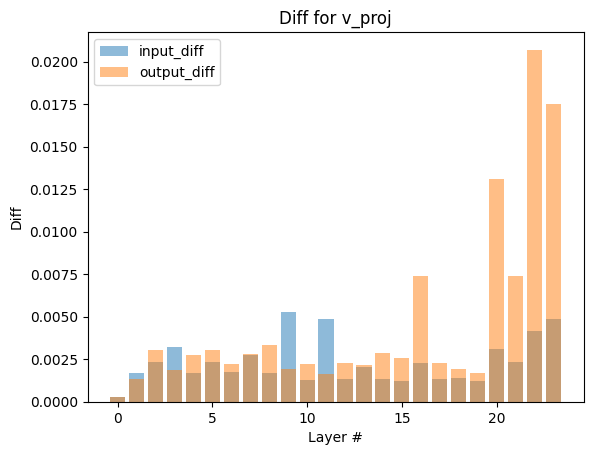

In [164]:
easy_compare_forward_hook_data(
    hook_data_path_1 = hook_data_path_1_1, 
    hook_data_path_2 = hook_data_path_2_1,
    forward_hook_module_names = forward_hook_module_names[:],
)

## Case 2

测试了非常多相似的prompts，导出在`strawberry-X`下面，测试脚本如下：



```python
def decode_pipeline_test():
	logging.info("Decode unittest ...")
	model_id = 0
	model_name_or_path = os.path.join(model_home, model_names[model_id])
	logging.info(f"  - Model: {model_name_or_path}")
	prompts = \
		[f"""英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
		[f"""({i})英文单词strawberry中有几个字母{i}？""" for i in range(1, 10)] + \
		[f"""({i})英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
		[
			"""（ii）英文单词strawberry中有几个字母r？""",
			"""（iii）英文单词strawberry中有几个字母r？""",
			"""（iv）英文单词strawberry中有几个字母r？""",
			"""（vi）英文单词strawberry中有几个字母r？""",
			"""（vii）英文单词strawberry中有几个字母r？""",
			"""（viii）英文单词strawberry中有几个字母r？""",
			"""（ix）英文单词strawberry中有几个字母r？""",
		]
	max_length = 4
	use_kv_cache = True
	forward_hook_module_names = \
		[f"model.embed_tokens", "model.rotary_emb", "model.norm"] + \
		[f"model.layers[{i}].self_attn.q_proj" for i in range(24)] + \
		[f"model.layers[{i}].self_attn.k_proj" for i in range(24)] + \
		[f"model.layers[{i}].self_attn.v_proj" for i in range(24)] + \
		[f"model.layers[{i}].self_attn.o_proj" for i in range(24)]

	for i in range(len(prompts)):
		returned_dict = decode_pipeline(
			model_name_or_path,
			prompts[i],
			max_length,
			device = None,
			use_kv_cache = use_kv_cache,
			forward_hook_module_names = forward_hook_module_names,
			backward_hook_module_names = None,
		)
		df_display = returned_dict["df_display"]
		forward_hook_data = returned_dict["forward_hook_data"]
		backward_hook_data = returned_dict["backward_hook_data"]
		# Save returned data
		save_path = f"./temp/decode+{model_names[model_id].split('/')[-1]}+{use_kv_cache}-{i}.csv"
		logging.info(f"Export table to {save_path}")
		df_display.to_csv(save_path, sep='\t', header=True, index=False)
		if forward_hook_data is not None:
			save_path = f"./temp/fhook+{model_names[model_id].split('/')[-1]}+{use_kv_cache}-{i}.pt"
			logging.info(f"Export forward hook data to {save_path}")
			torch.save(forward_hook_data, save_path)
		if backward_hook_data is not None:
			save_path = f"./temp/bhook+{model_names[model_id].split('/')[-1]}+{use_kv_cache}-{i}.pt"
			logging.info(f"Export backward hook data to {save_path}")
			torch.save(backward_hook_data, save_path)
		logging.info("  - OK!")
```

注意RoPE会有两个输入：


- 从绝对位置编码到相对位置编码
    - 绝对位置编码，位置 pos_i 的编码仅取决于 pos_i 的值；
    - 相对位置编码，（一般不需要对每个位置进行单独的编码），而是直接对位置之间的相对距离进行编码
        - pos=0 与 pos=1 的相对位置 $f(|0-1|)$
        - pos=1 与 pos=3 的相对位置 $f(|1-3|)$
        - 偏差构成的矩阵，称为 id 矩阵；
- RoPE
    - 旋转位置编码，为相对位置编码，非加性位置编码，直接嵌入到 attention mechanism 的计算中；
    - $R^d_{\Theta,m}$：位置 $m$ 对应的旋转矩阵 not learnable：非学习的，全局固定的；
        - $m\theta$：frequency


$$
\begin{split}
f(q,m)^Tf(k,n)&=(R_mq)^T(R_nk)\\
&=q^T(R^T_mR_n)k\\
&=q^TR_{n-m}k
\end{split}
$$

freqs_cis 是一个全局的旋转矩阵：
```python
xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)
xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
xq, xk, xv
```

In [167]:
forward_hook_module_names = \
    [f"model.embed_tokens", "model.rotary_emb", "model.norm"] + \
    [f"model.layers[{i}].self_attn.q_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.k_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.v_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.o_proj" for i in range(24)]

hook_data_path_formatter = "./results/strawberry-X/fhook+Qwen2.5-0.5B-Instruct+True-{}.pt"

In [185]:

prompts = \
    [f"""英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
    [f"""({i})英文单词strawberry中有几个字母{i}？""" for i in range(1, 10)] + \
    [f"""({i})英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
    [
        """（ii）英文单词strawberry中有几个字母r？""",
        """（iii）英文单词strawberry中有几个字母r？""",
        """（iv）英文单词strawberry中有几个字母r？""",
        """（vi）英文单词strawberry中有几个字母r？""",
        """（vii）英文单词strawberry中有几个字母r？""",
        """（viii）英文单词strawberry中有几个字母r？""",
        """（ix）英文单词strawberry中有几个字母r？""",
    ]

for i, prompt in enumerate(prompts):
    print(i, prompt)

0 英文单词strawberry中有几个字母a？
1 英文单词strawberry中有几个字母b？
2 英文单词strawberry中有几个字母c？
3 英文单词strawberry中有几个字母d？
4 英文单词strawberry中有几个字母e？
5 英文单词strawberry中有几个字母f？
6 英文单词strawberry中有几个字母g？
7 英文单词strawberry中有几个字母h？
8 英文单词strawberry中有几个字母i？
9 英文单词strawberry中有几个字母j？
10 英文单词strawberry中有几个字母k？
11 英文单词strawberry中有几个字母l？
12 英文单词strawberry中有几个字母m？
13 英文单词strawberry中有几个字母n？
14 英文单词strawberry中有几个字母o？
15 英文单词strawberry中有几个字母p？
16 英文单词strawberry中有几个字母q？
17 英文单词strawberry中有几个字母r？
18 英文单词strawberry中有几个字母s？
19 英文单词strawberry中有几个字母t？
20 英文单词strawberry中有几个字母u？
21 英文单词strawberry中有几个字母v？
22 英文单词strawberry中有几个字母w？
23 英文单词strawberry中有几个字母x？
24 英文单词strawberry中有几个字母y？
25 英文单词strawberry中有几个字母z？
26 英文单词strawberry中有几个字母A？
27 英文单词strawberry中有几个字母B？
28 英文单词strawberry中有几个字母C？
29 英文单词strawberry中有几个字母D？
30 英文单词strawberry中有几个字母E？
31 英文单词strawberry中有几个字母F？
32 英文单词strawberry中有几个字母G？
33 英文单词strawberry中有几个字母H？
34 英文单词strawberry中有几个字母I？
35 英文单词strawberry中有几个字母J？
36 英文单词strawberry中有几个字母K？
37 英文单词strawberry中有几个字母L？
38 英文单词strawberry中有几个字

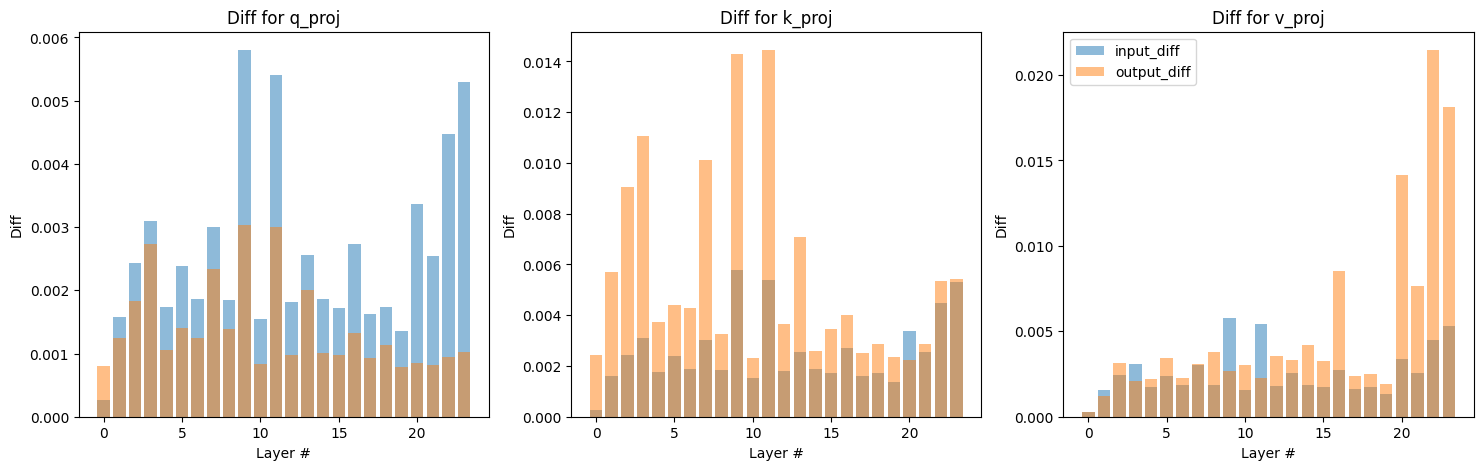

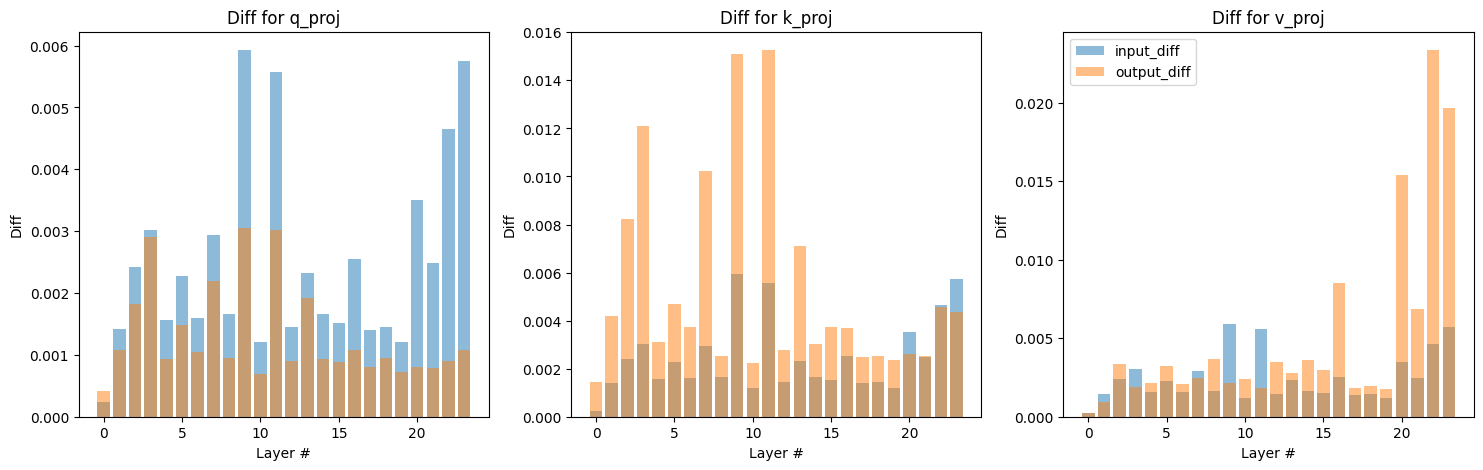

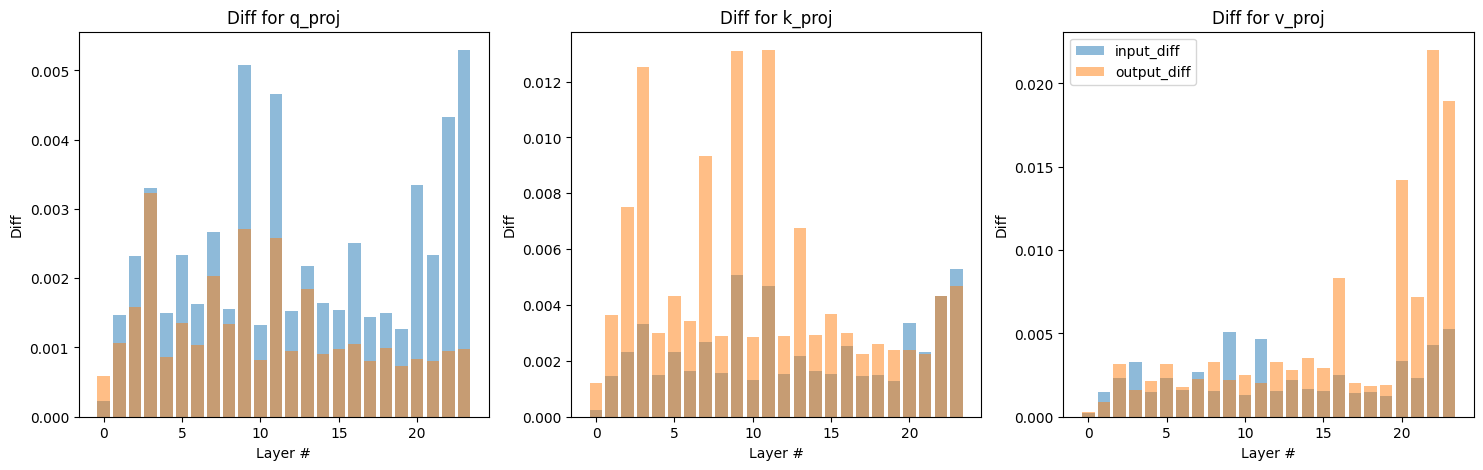

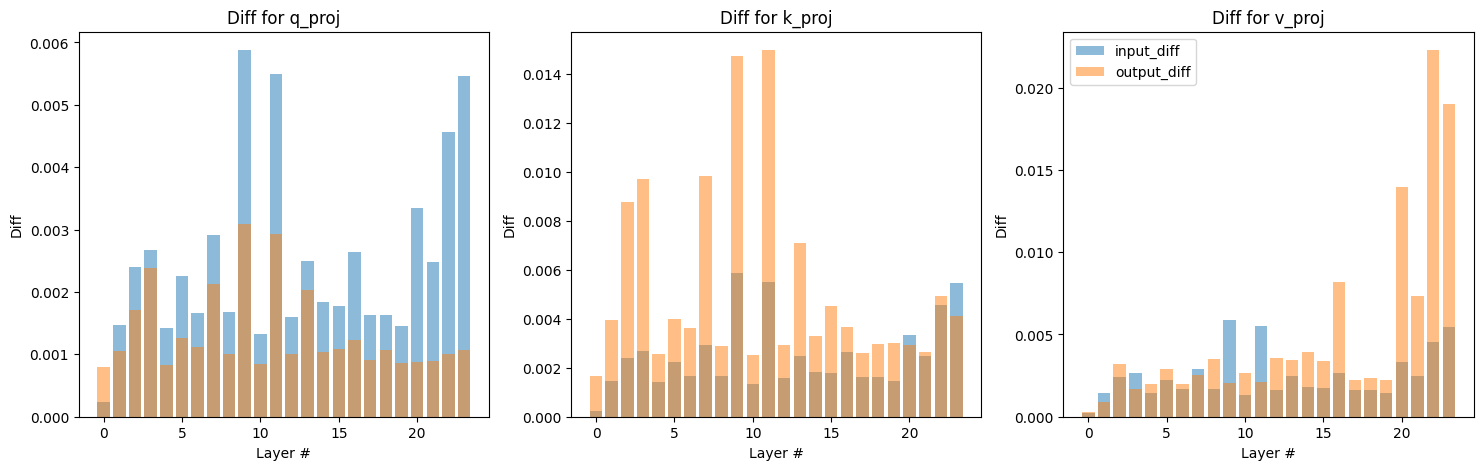

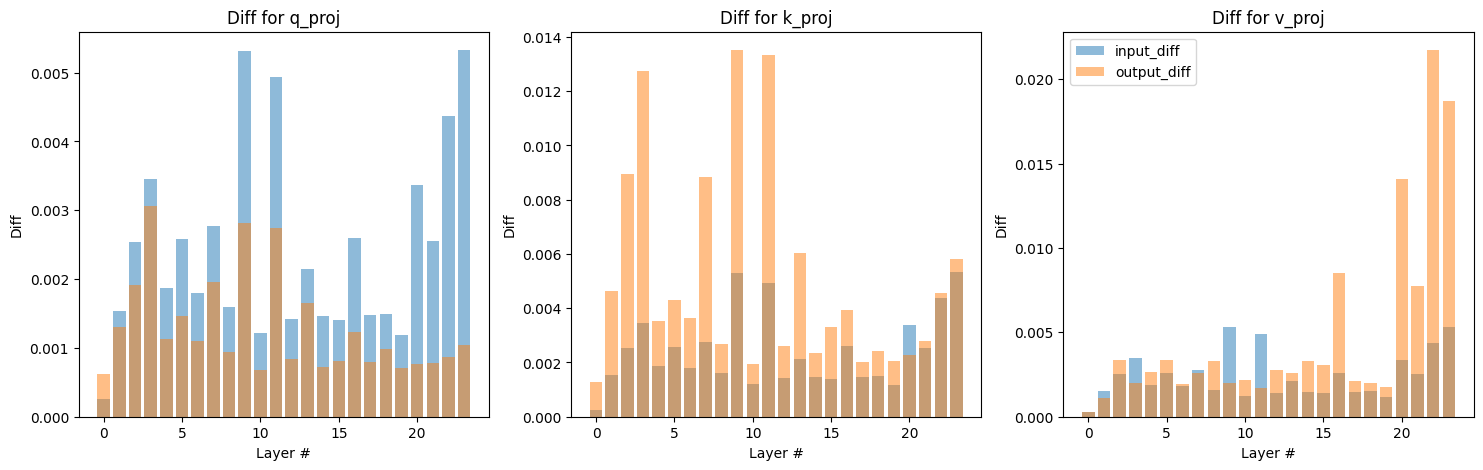

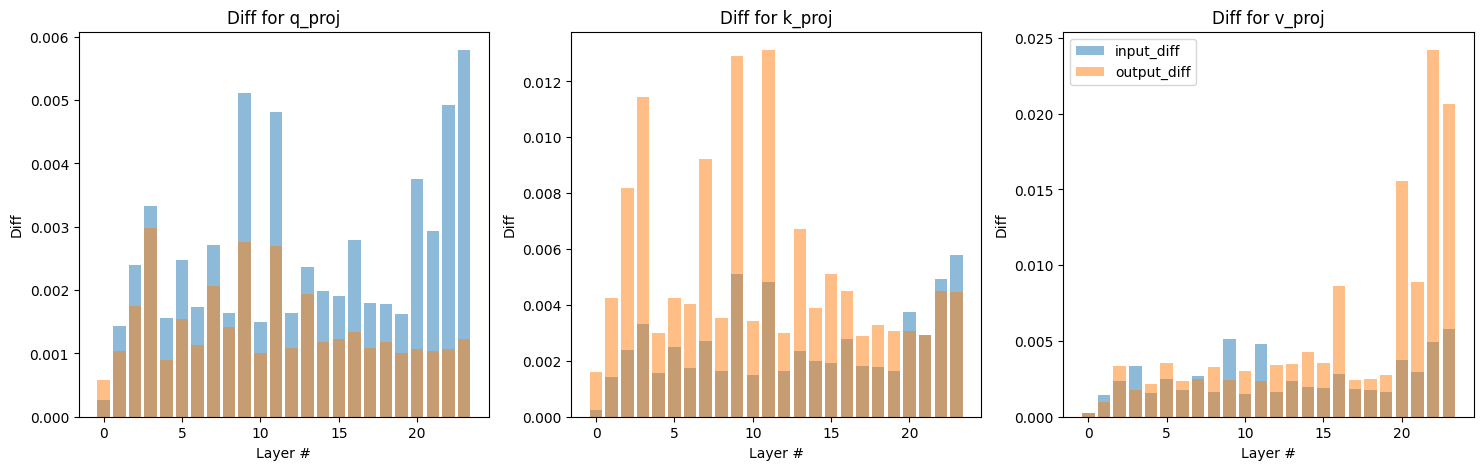

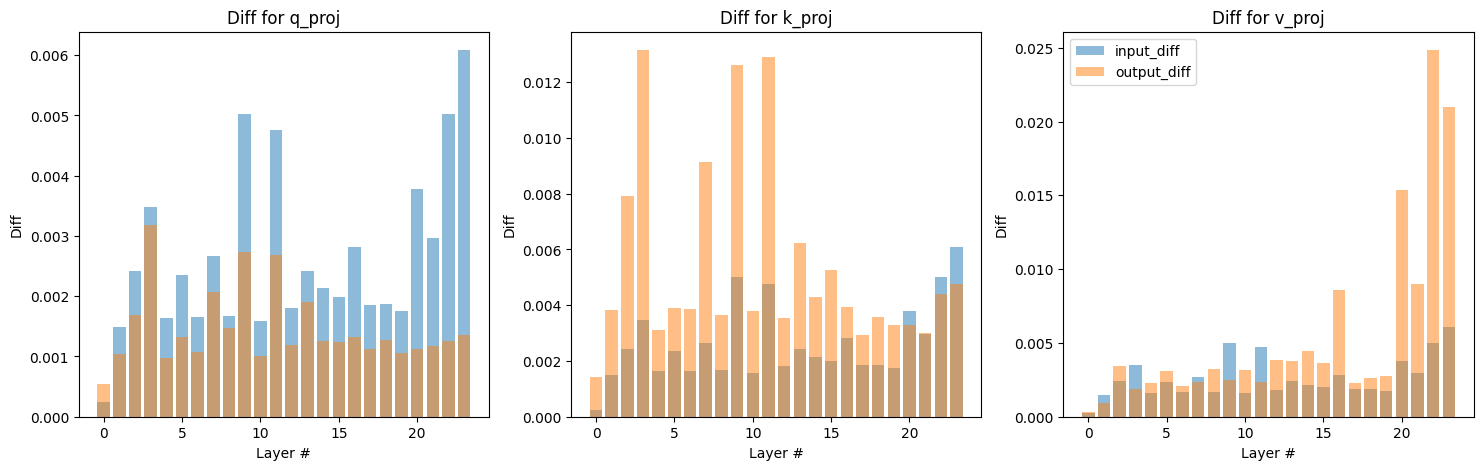

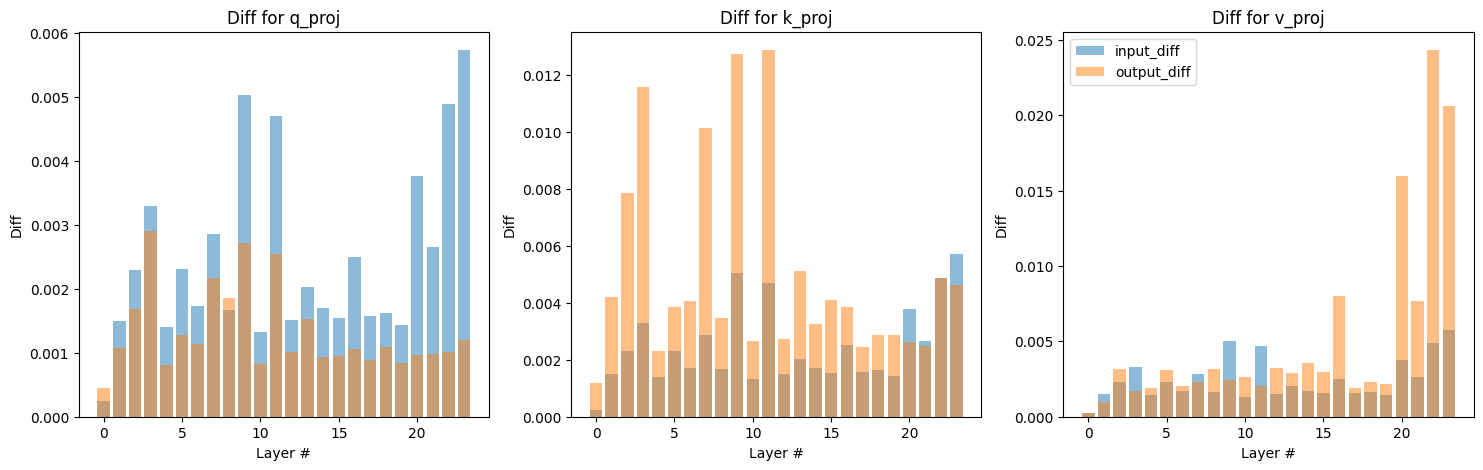

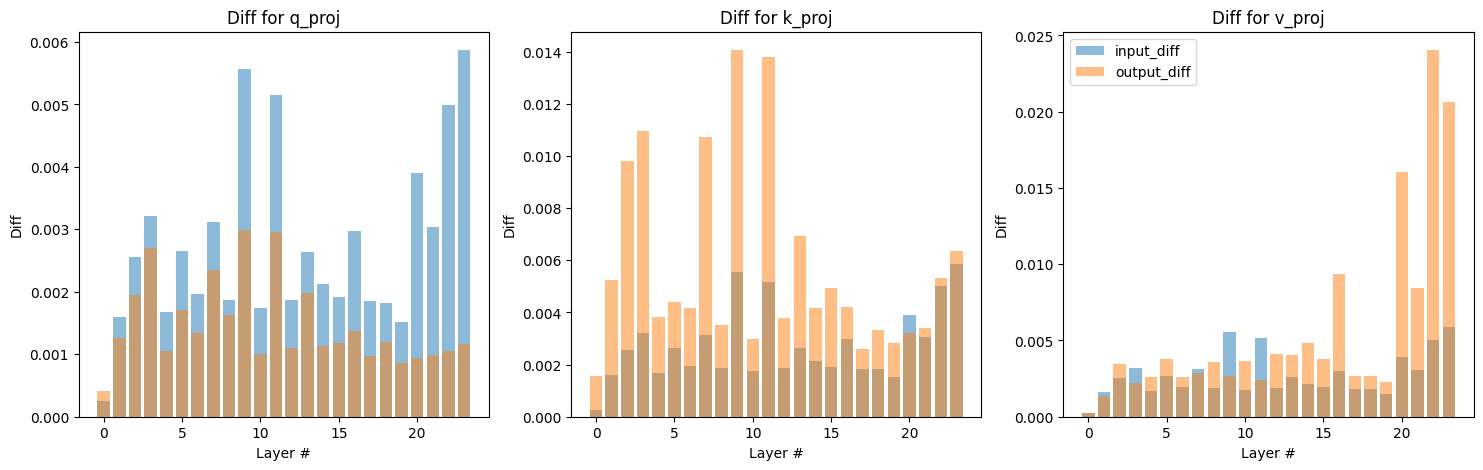

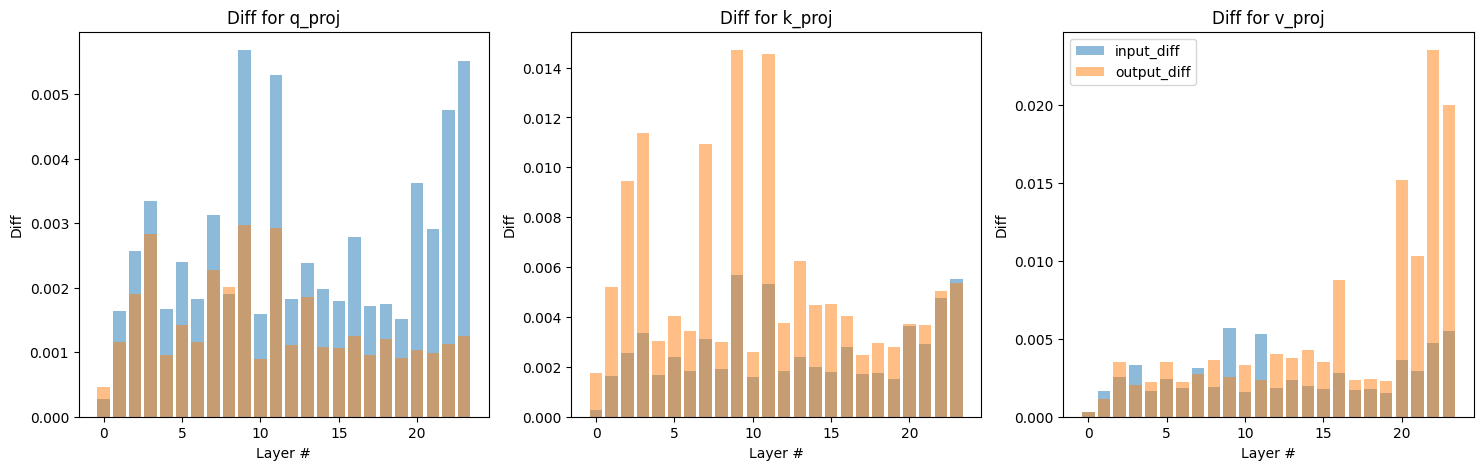

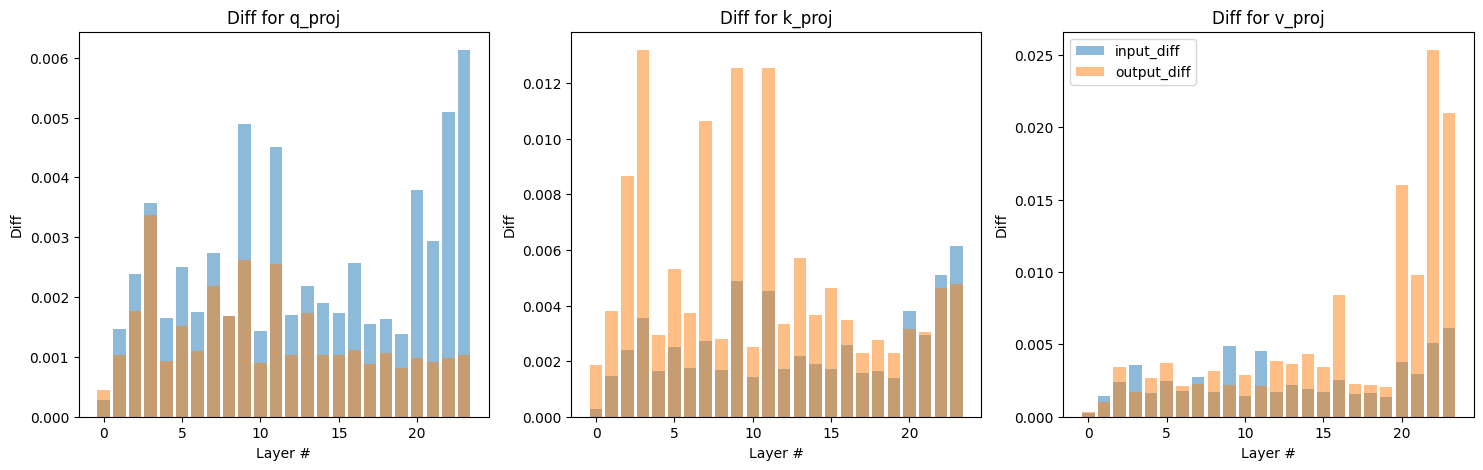

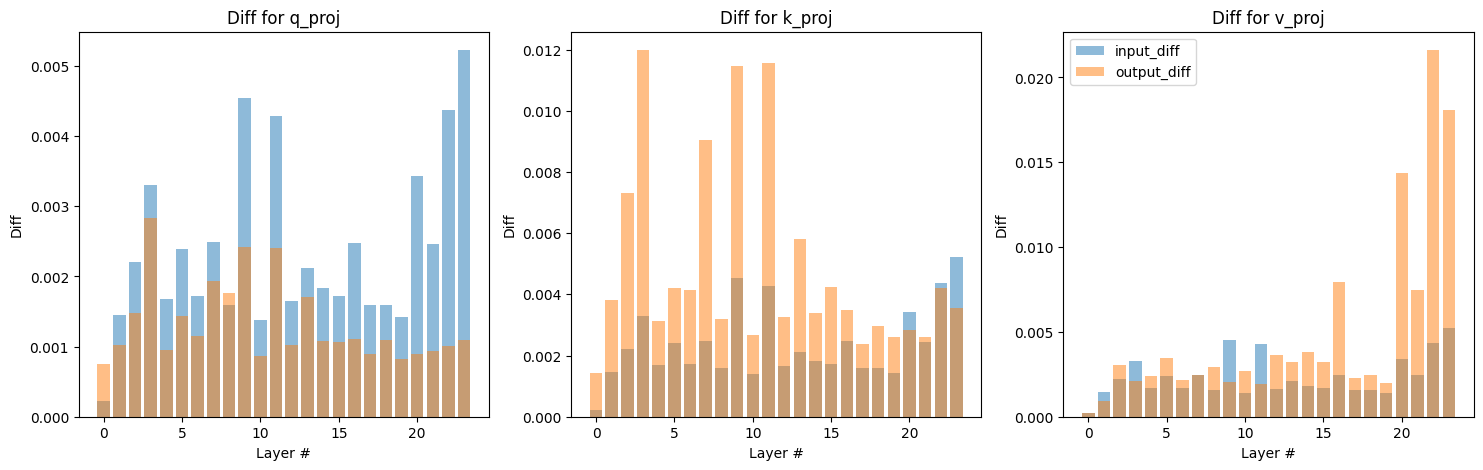

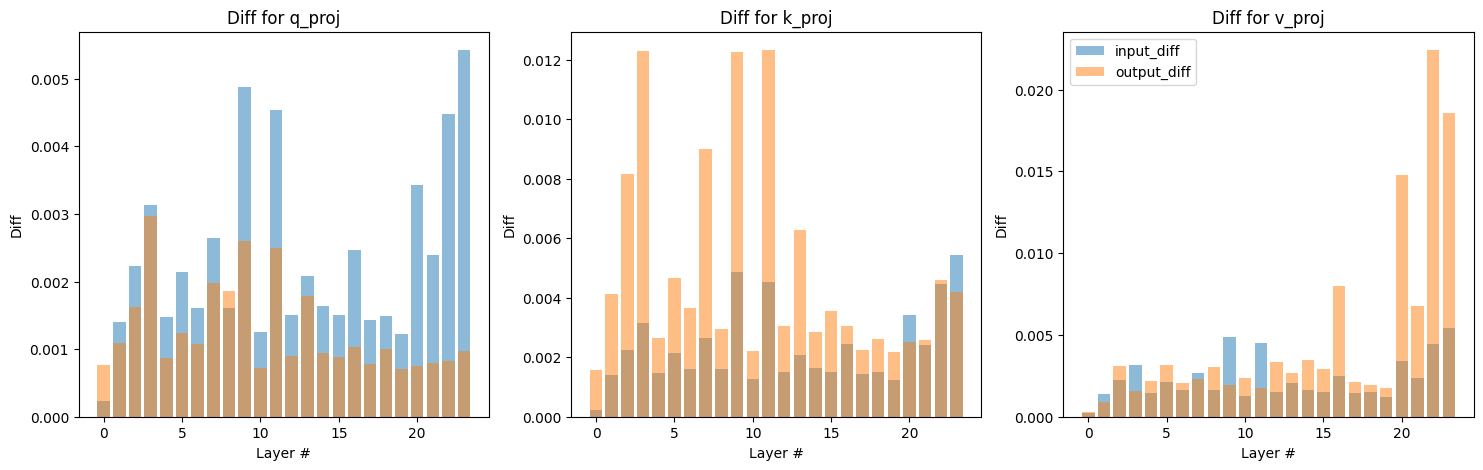

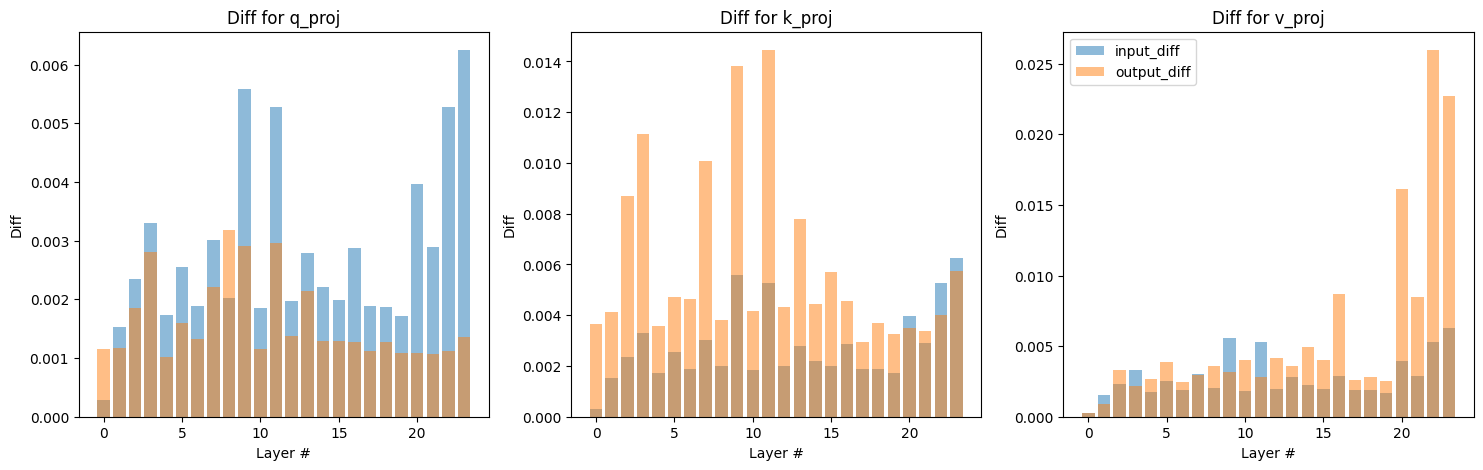

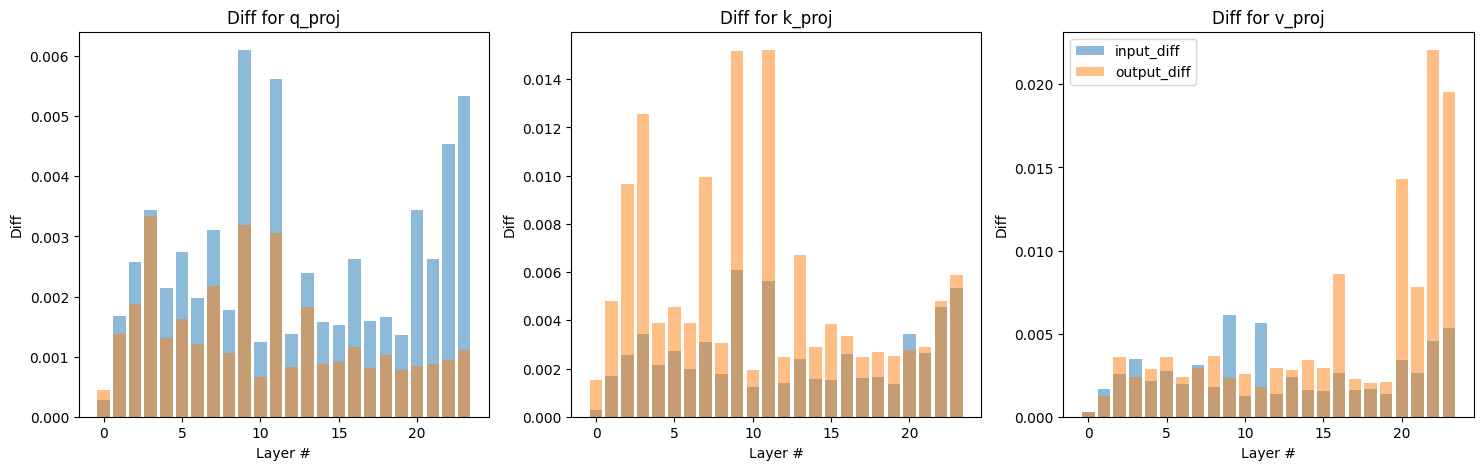

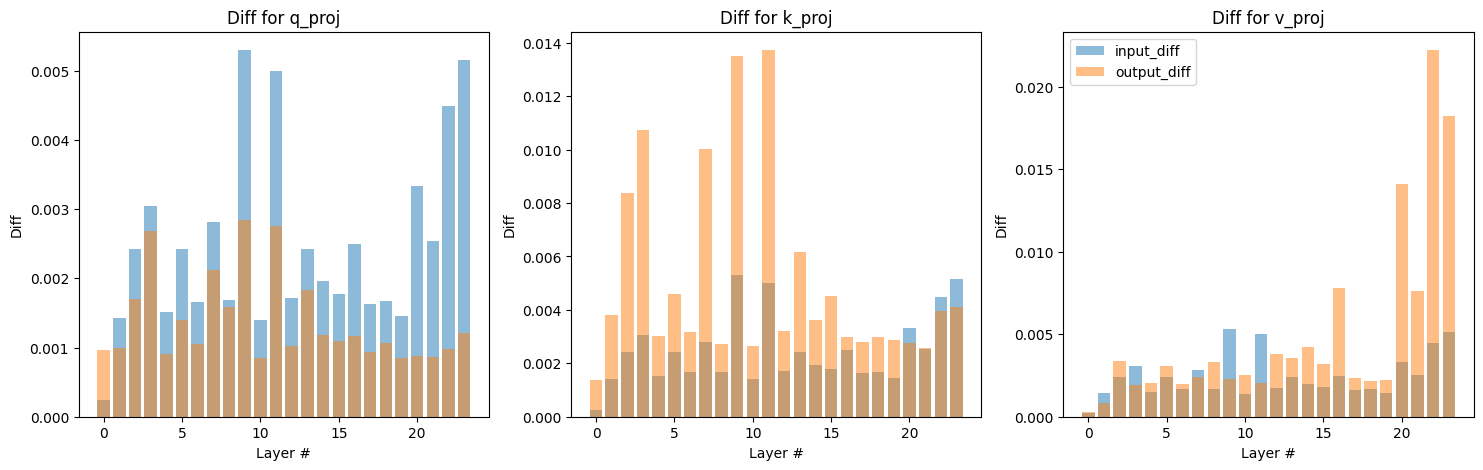

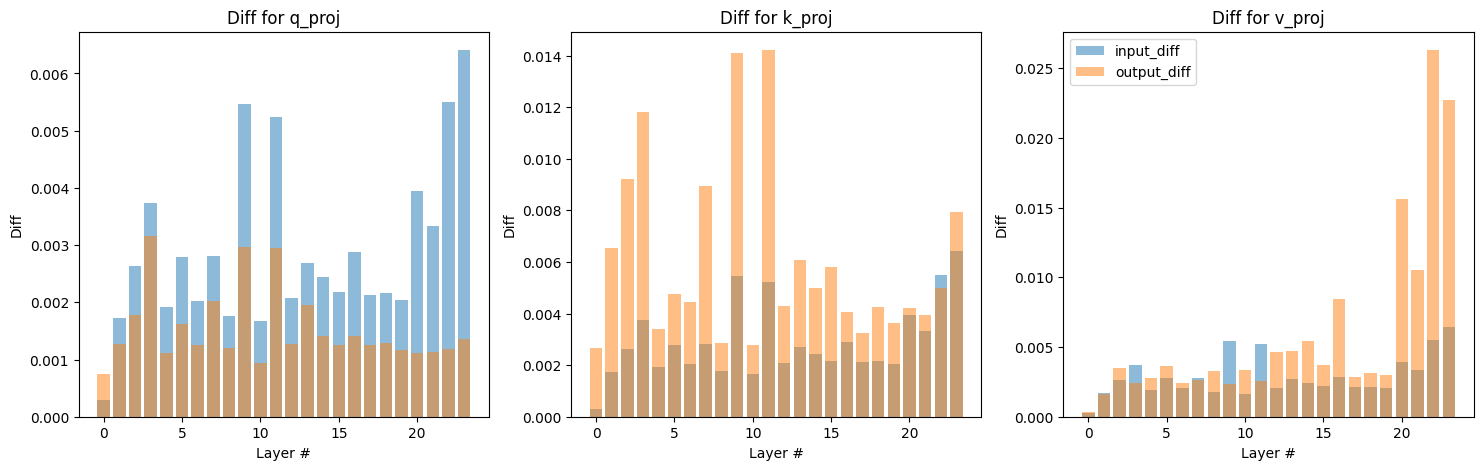

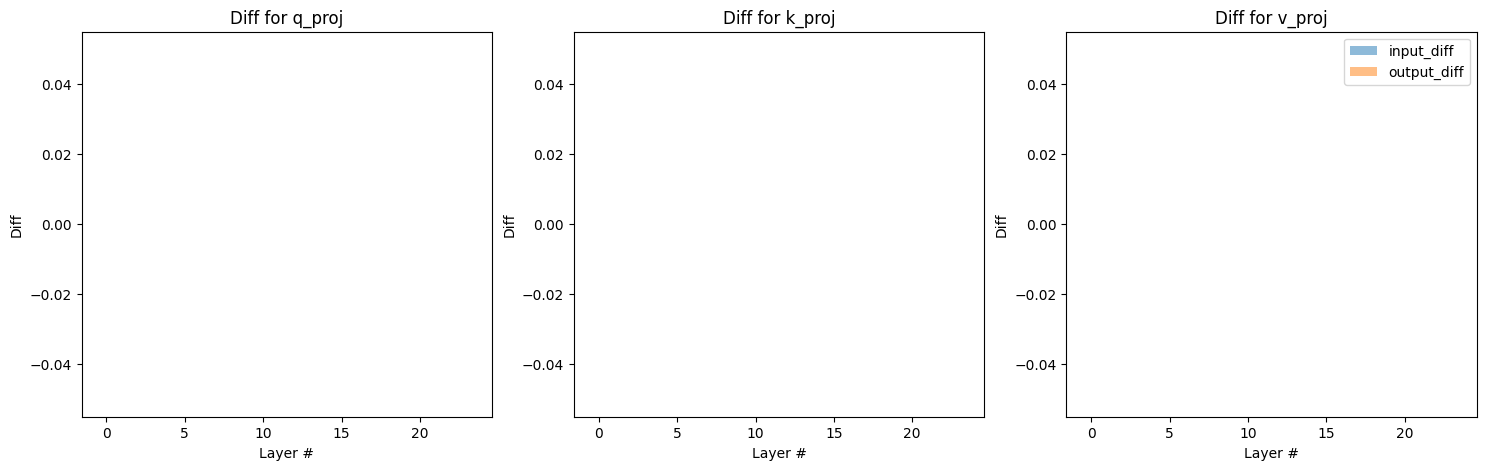

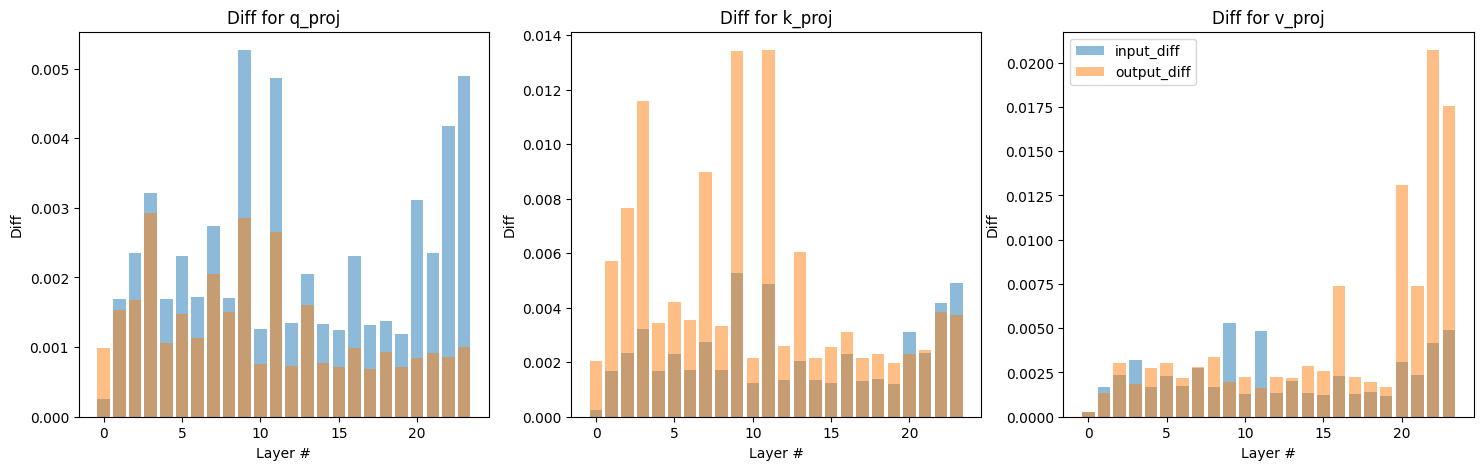

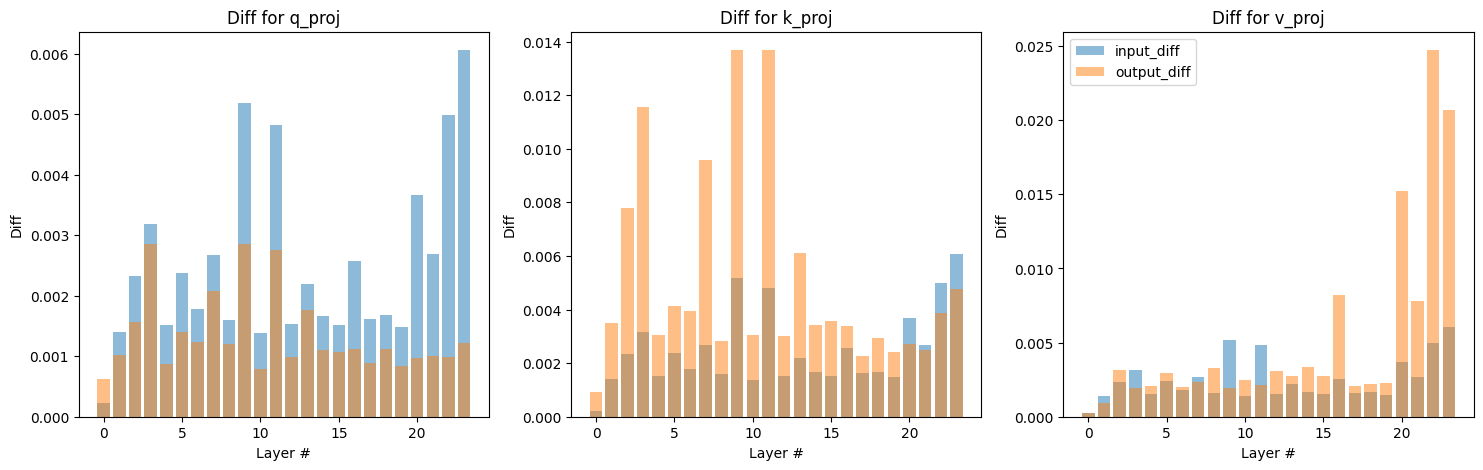

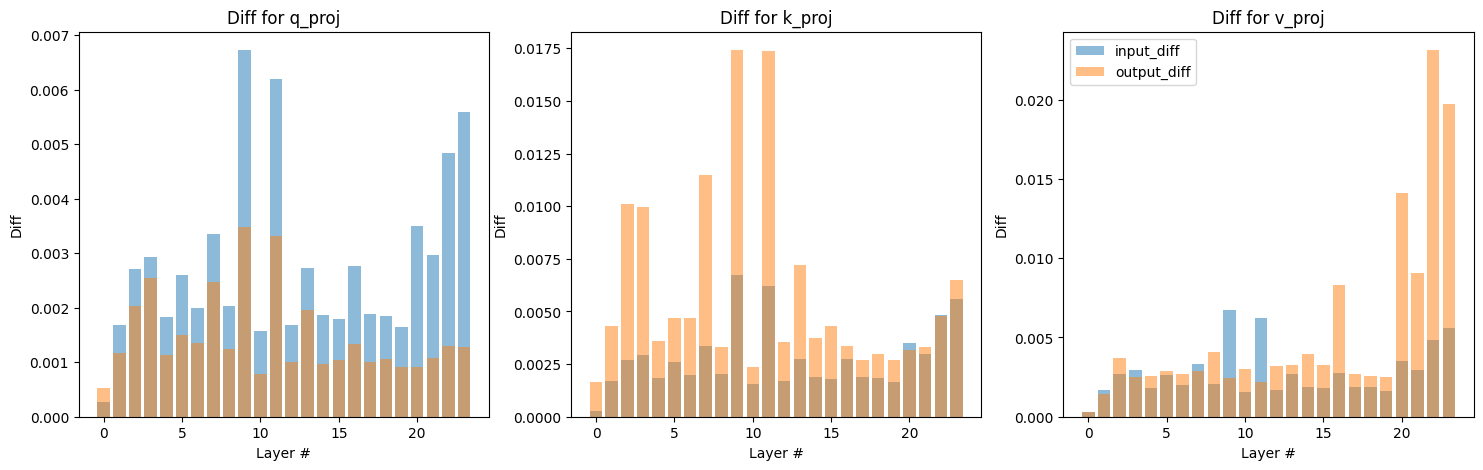

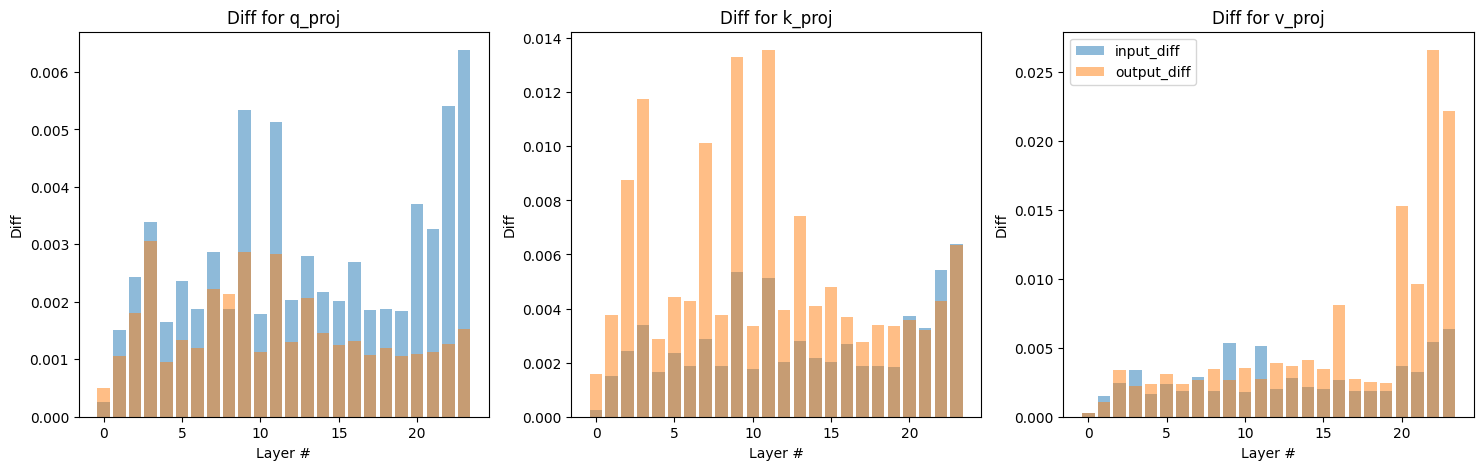

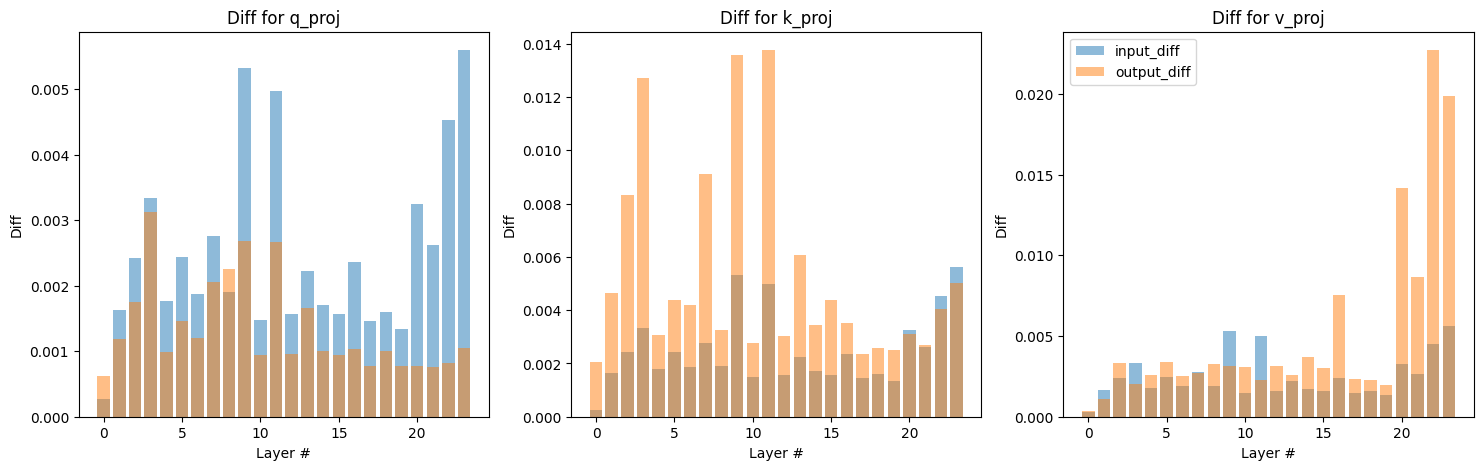

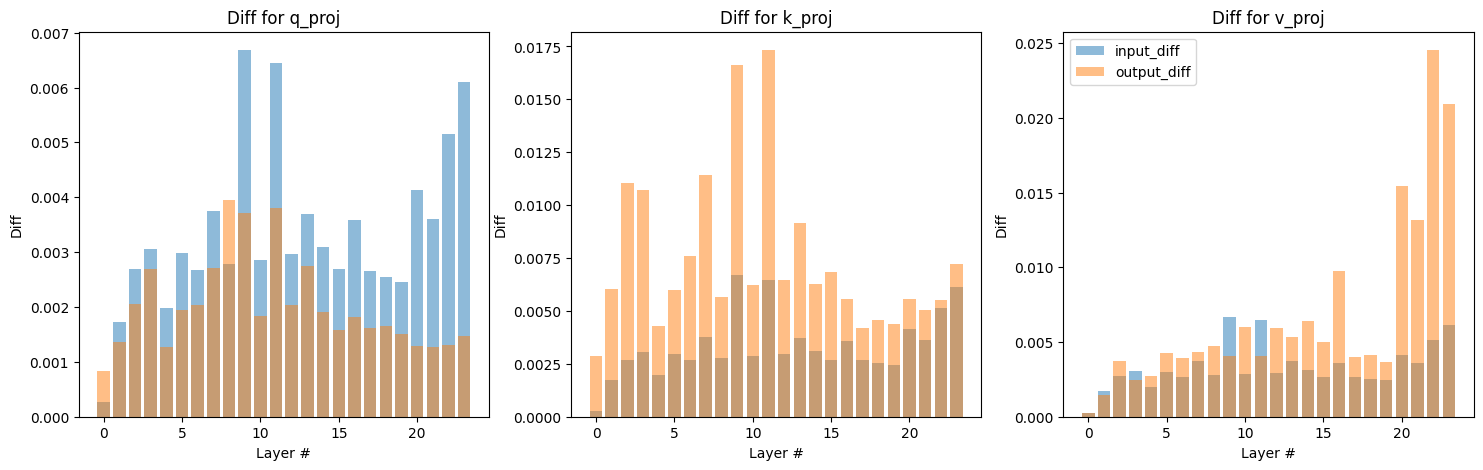

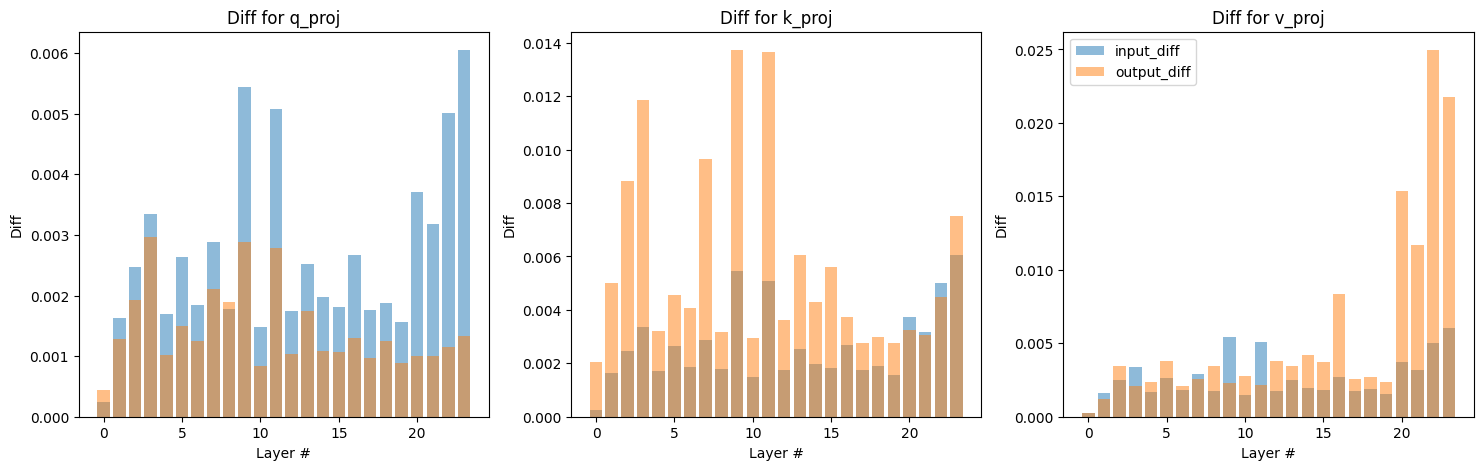

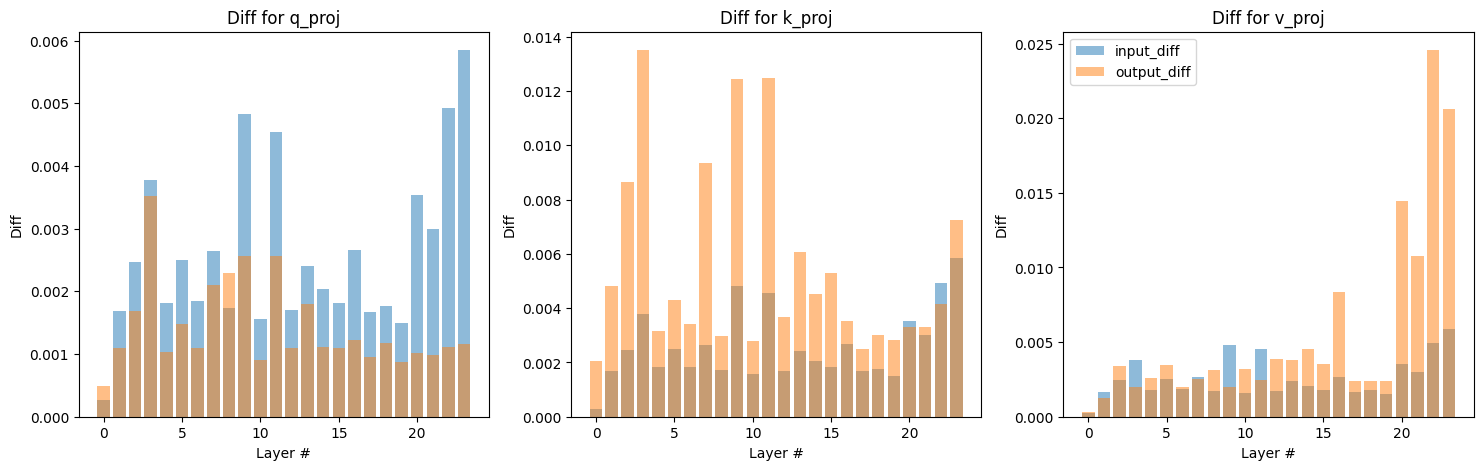

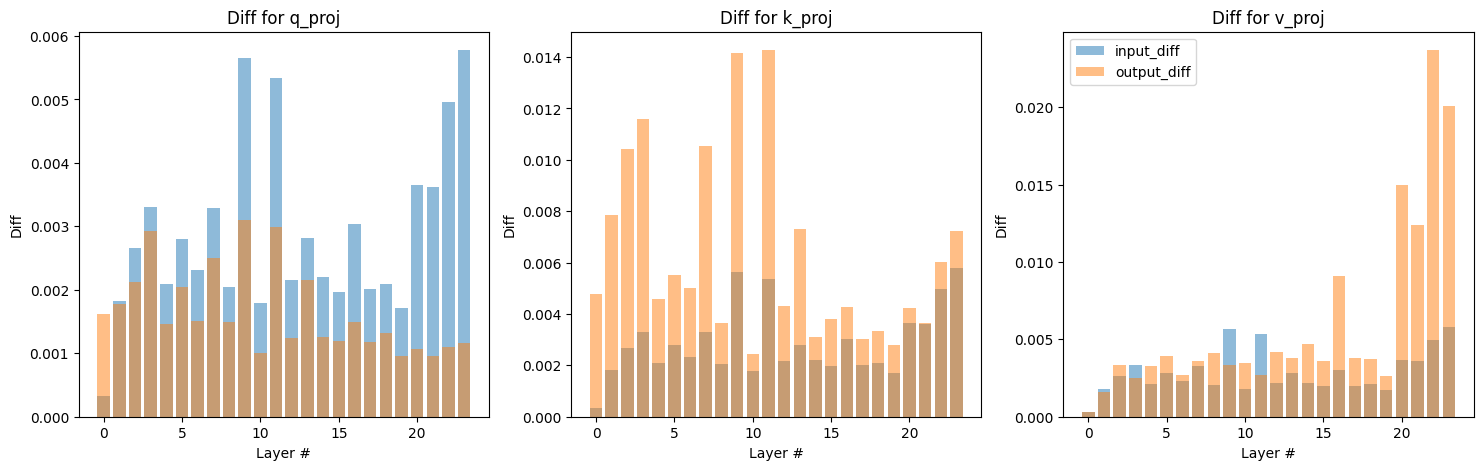

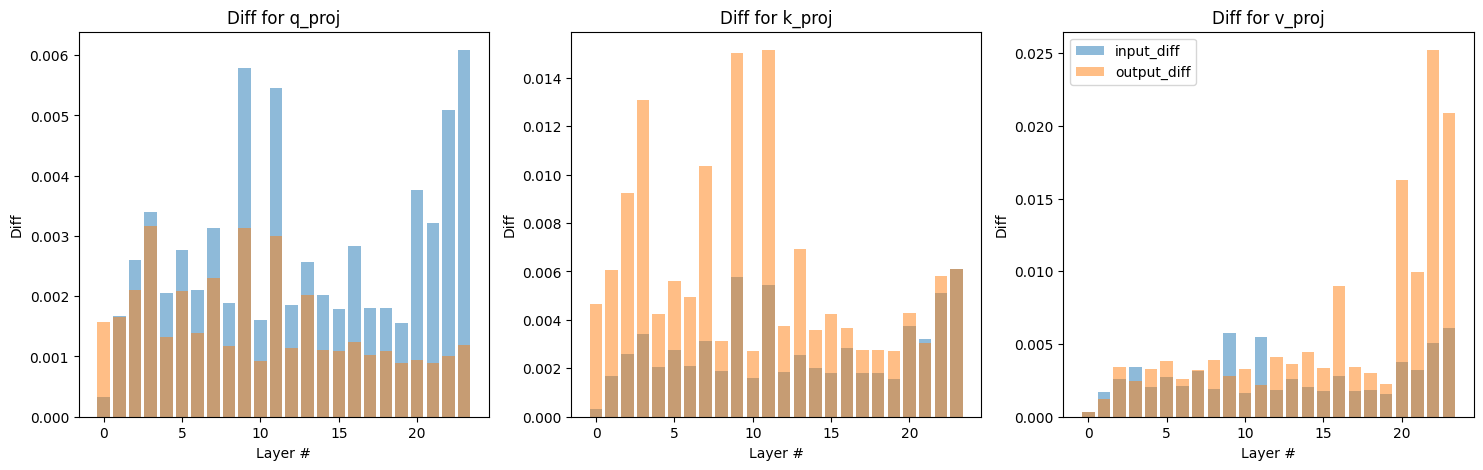

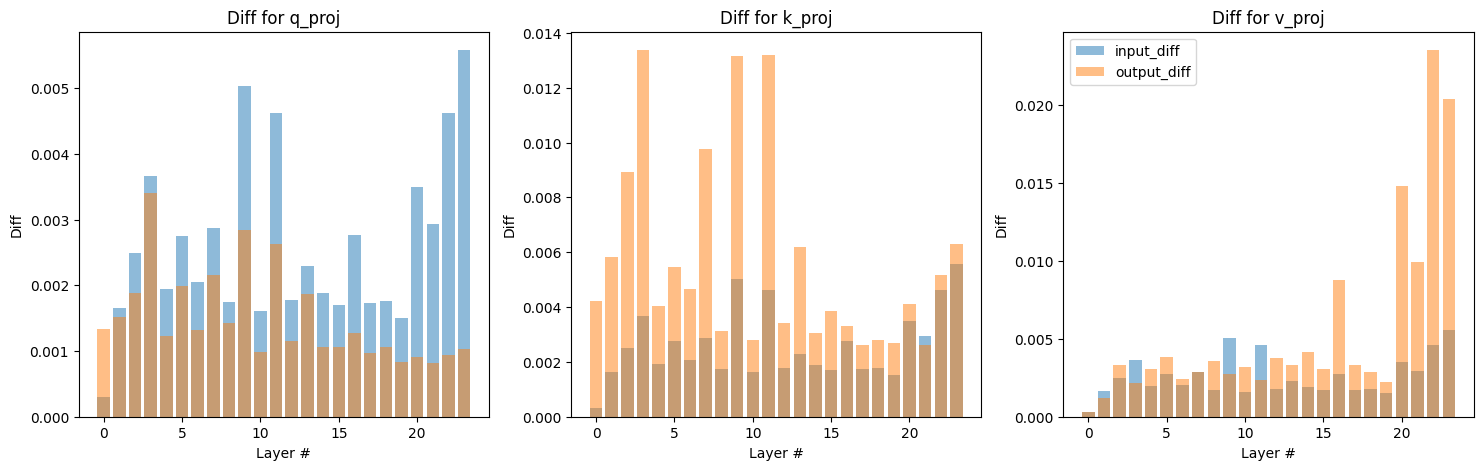

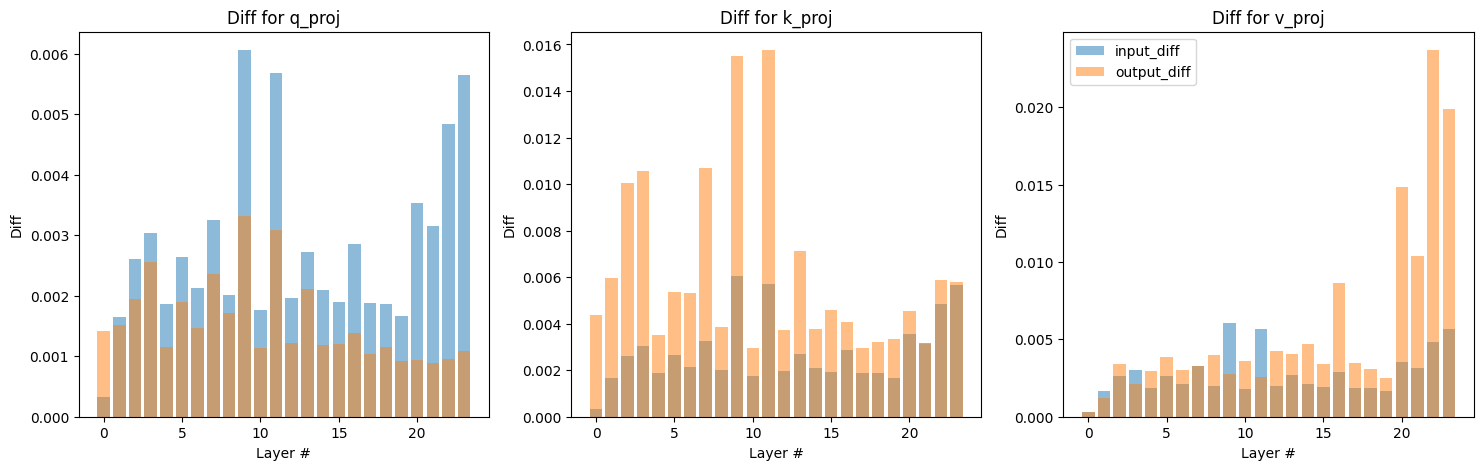

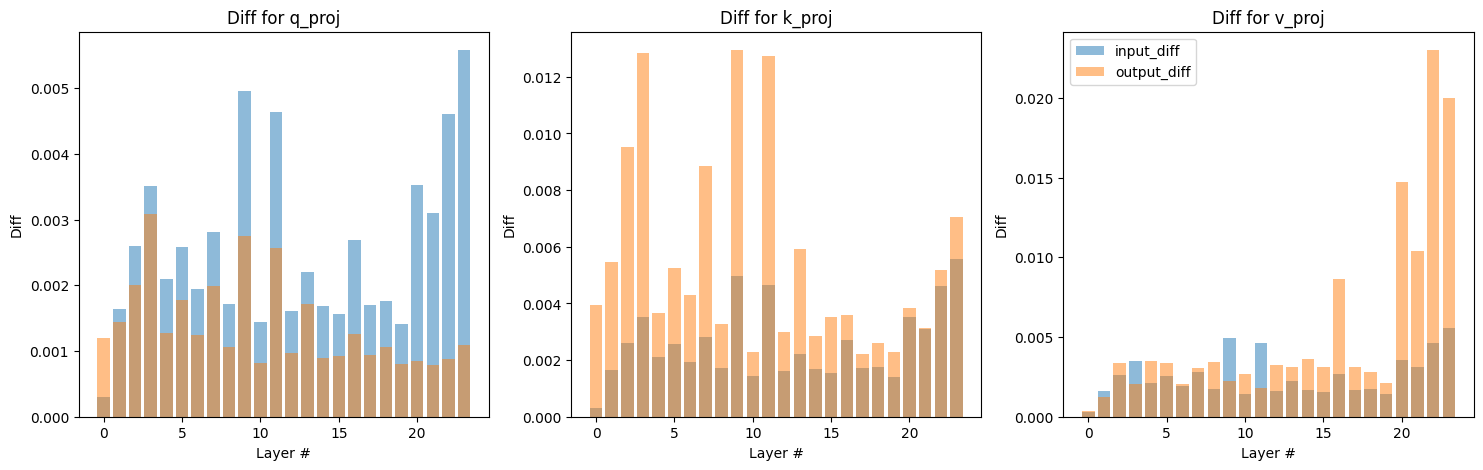

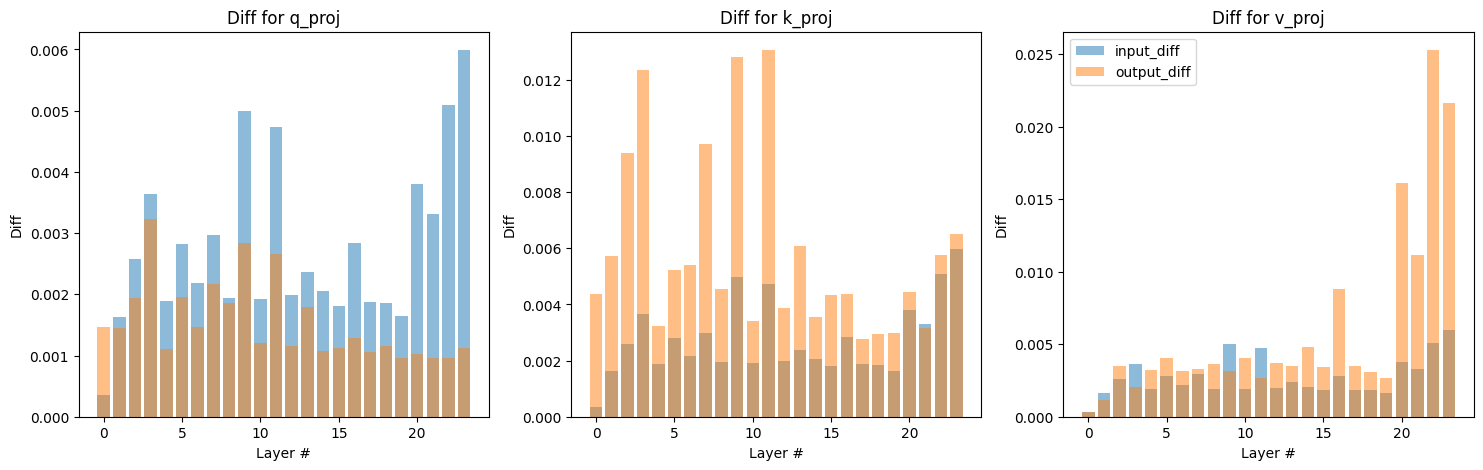

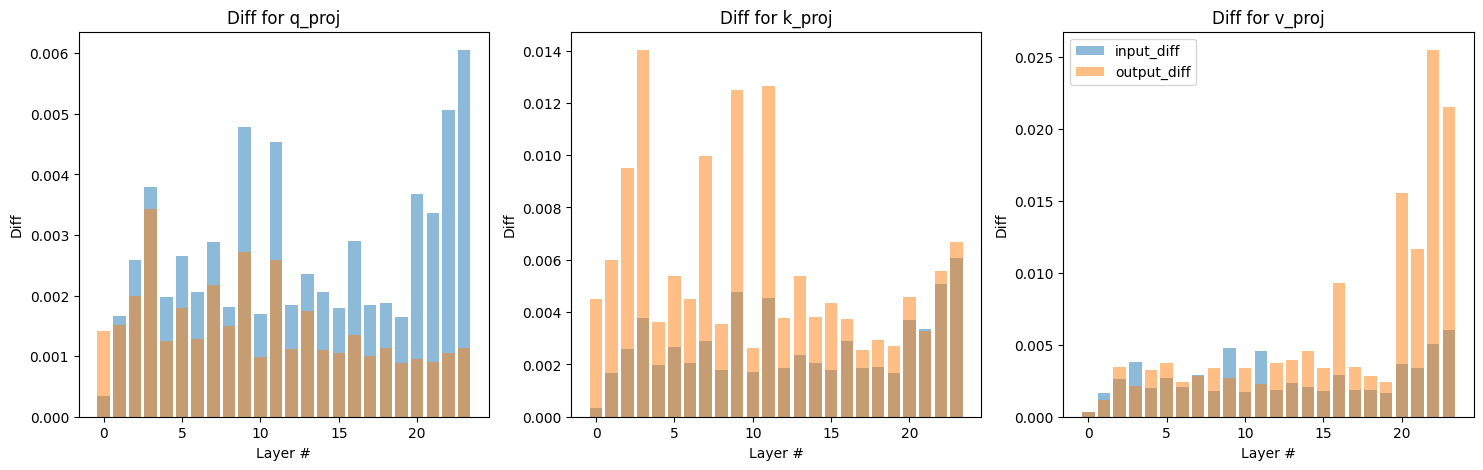

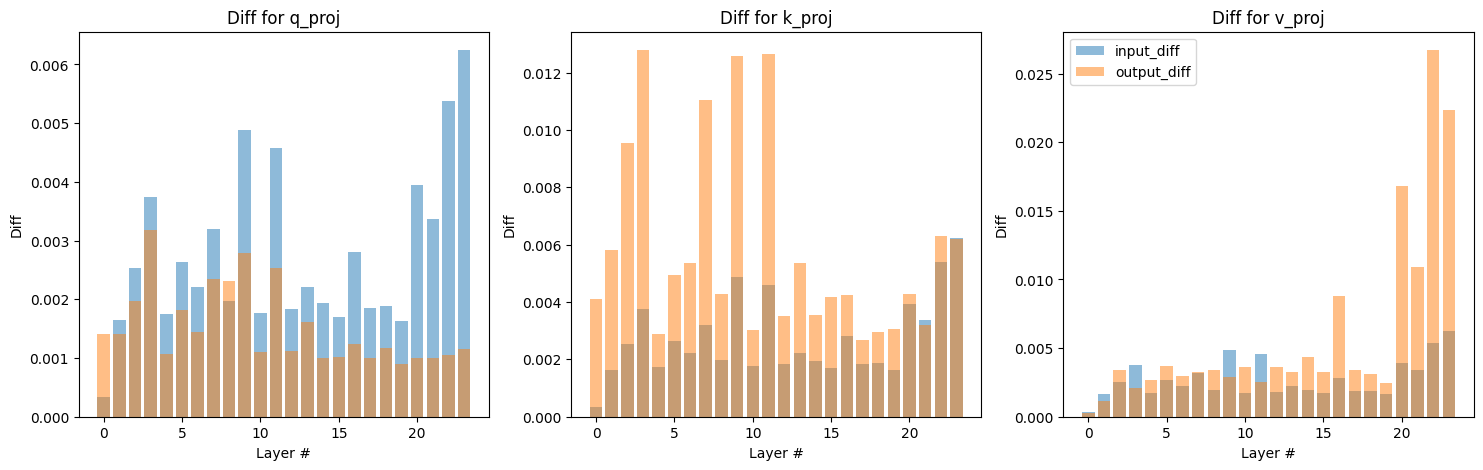

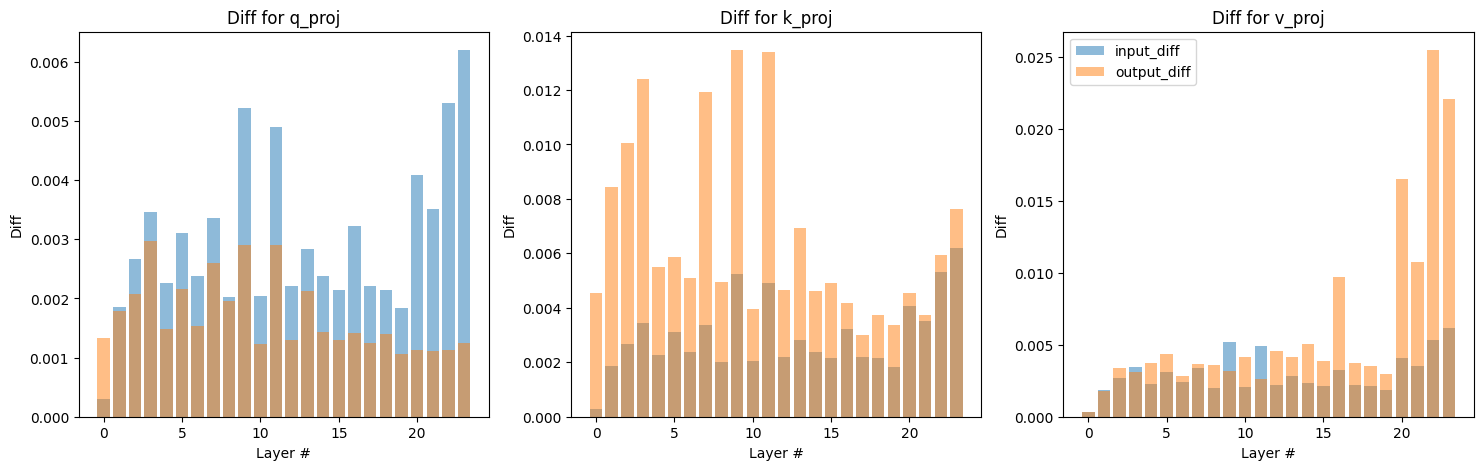

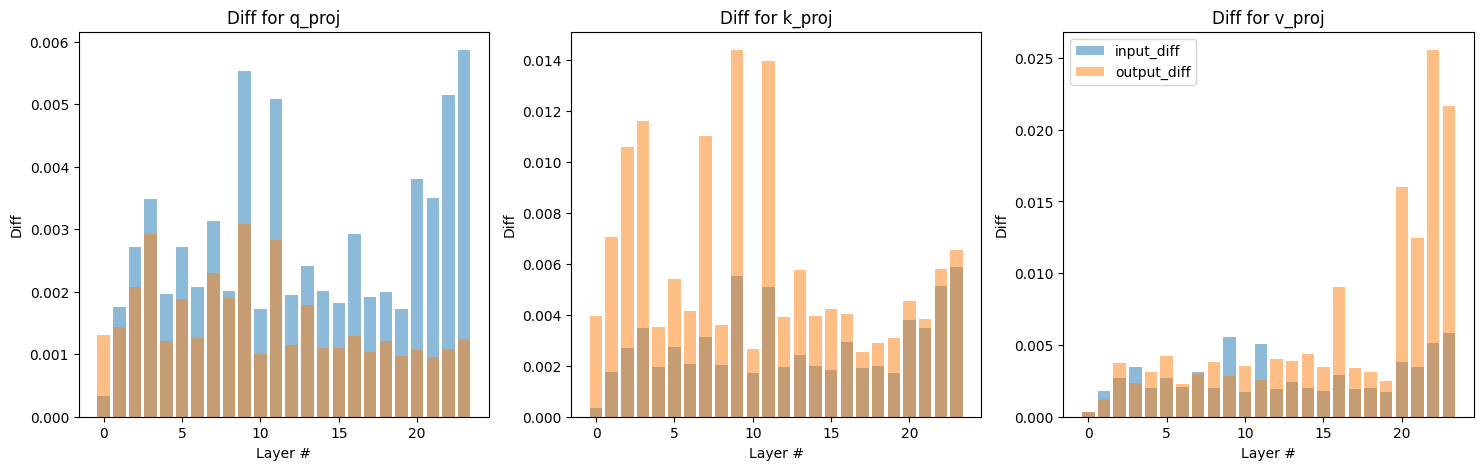

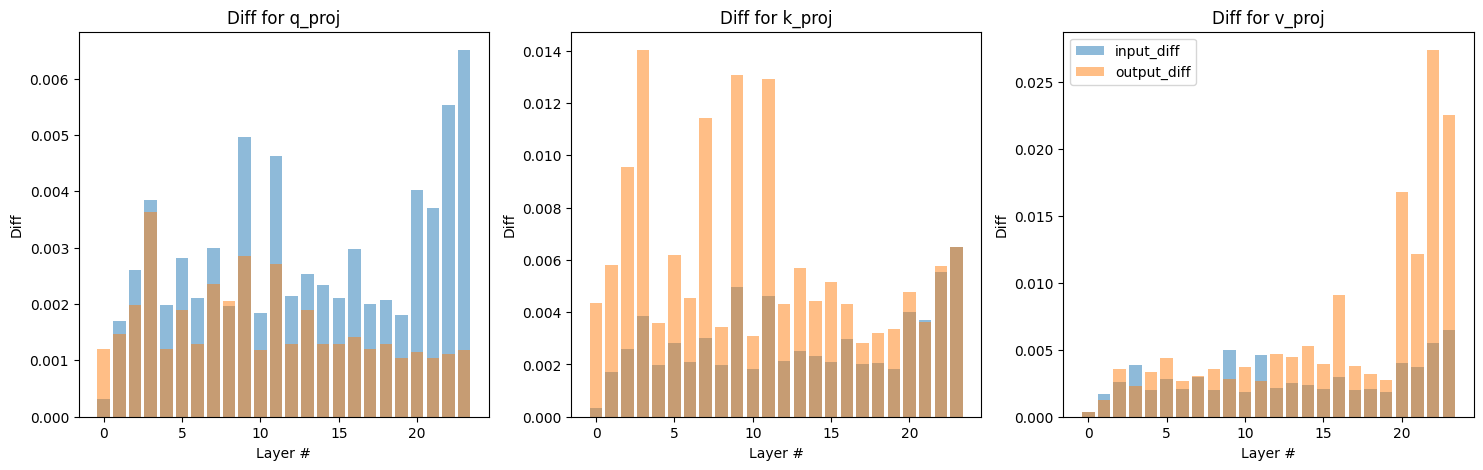

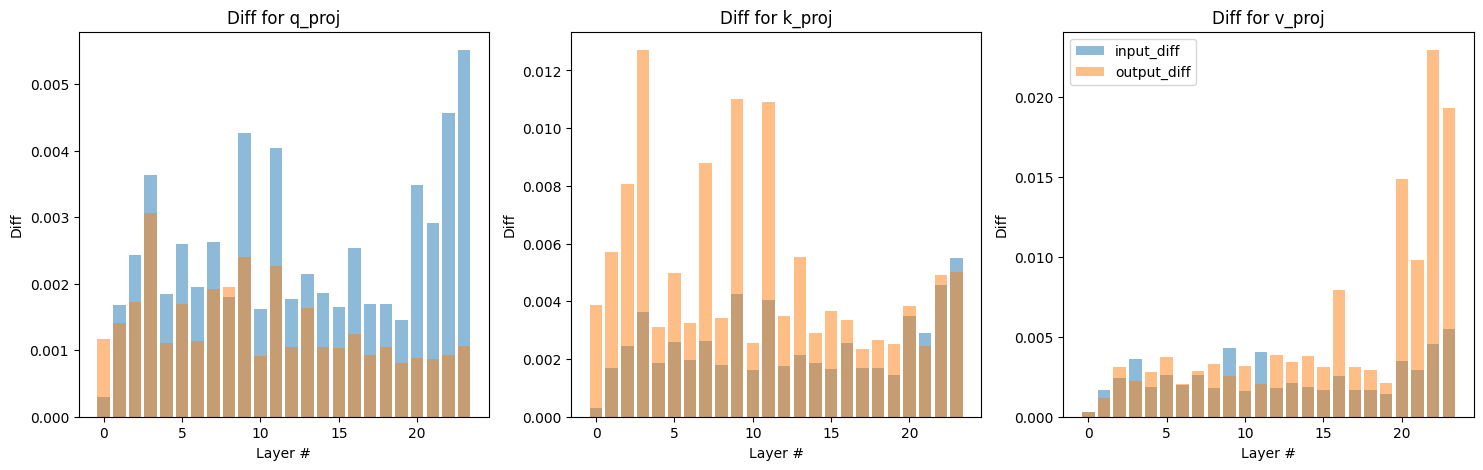

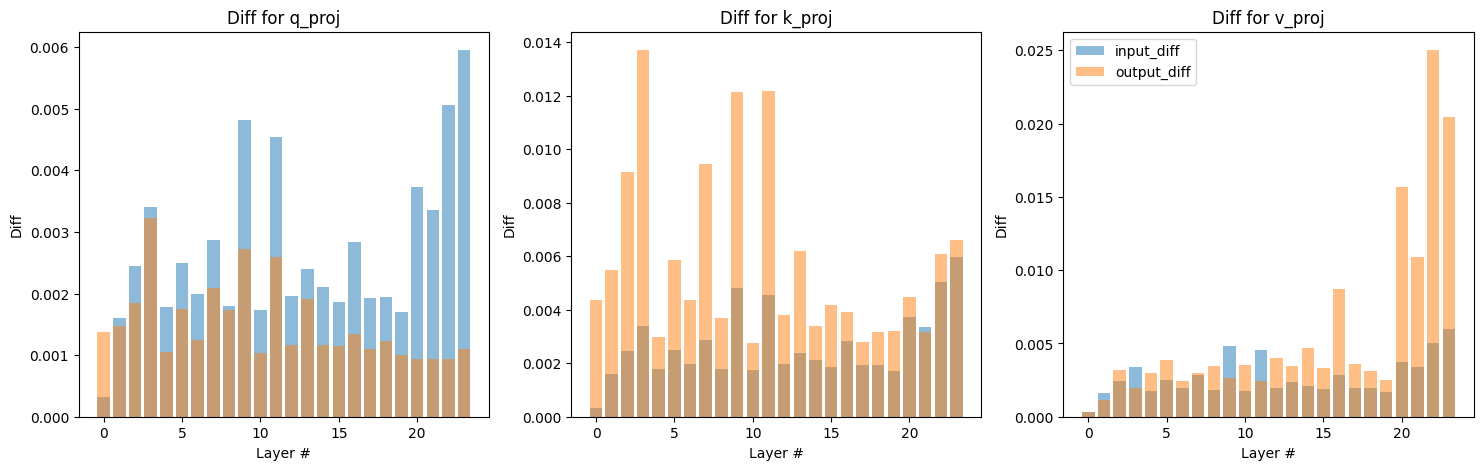

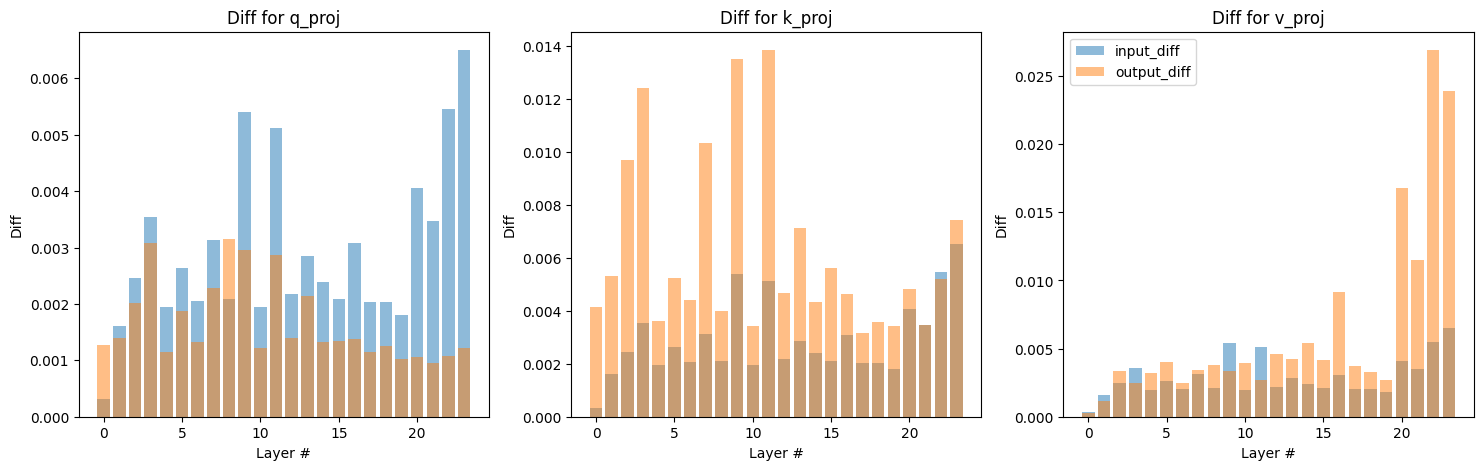

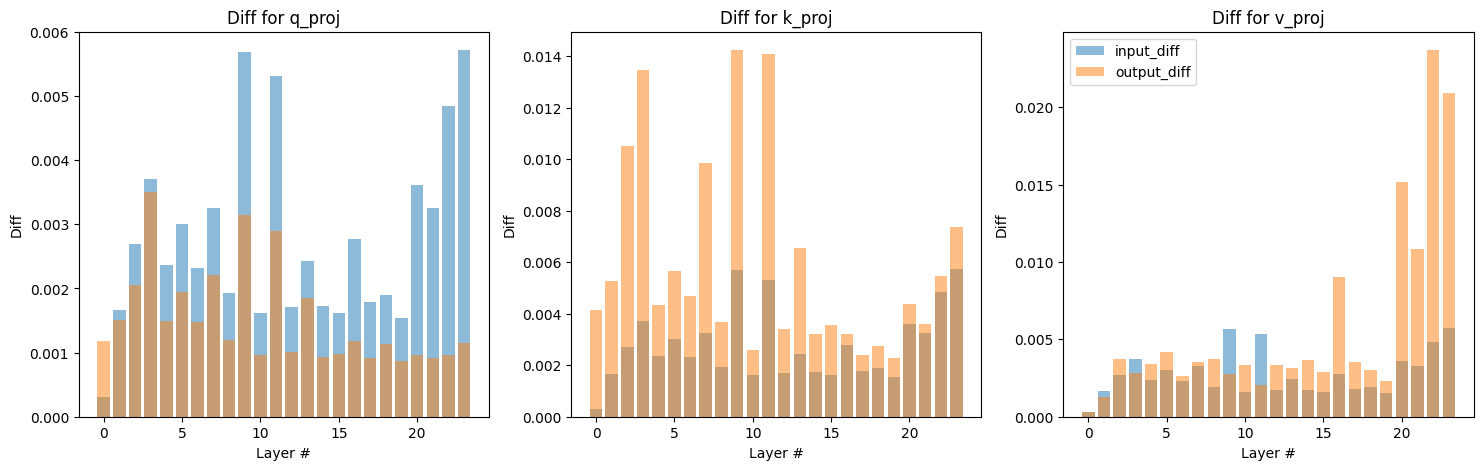

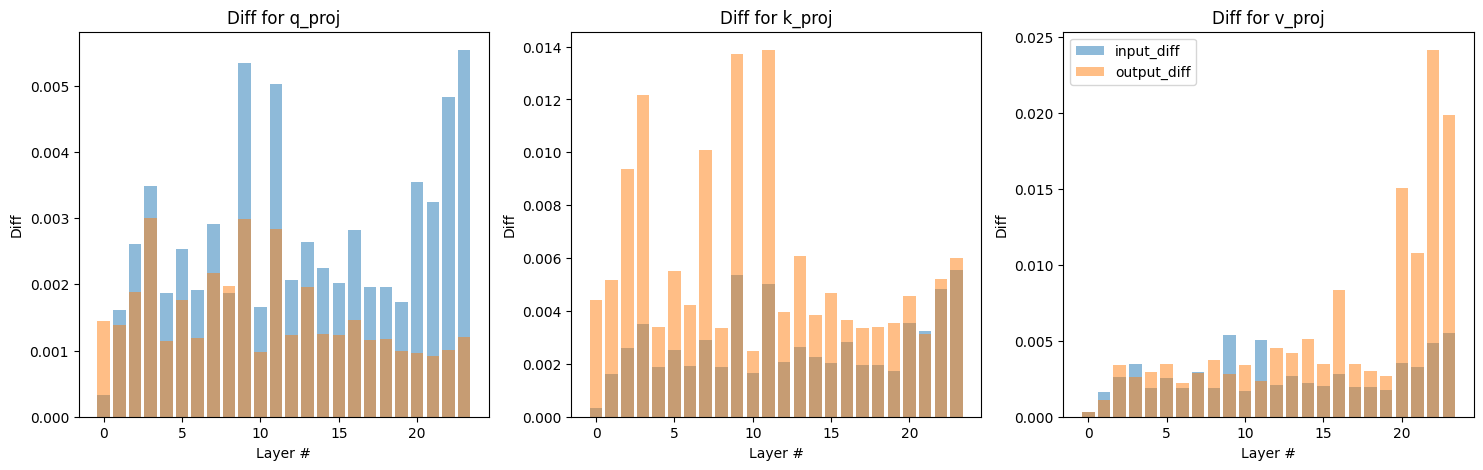

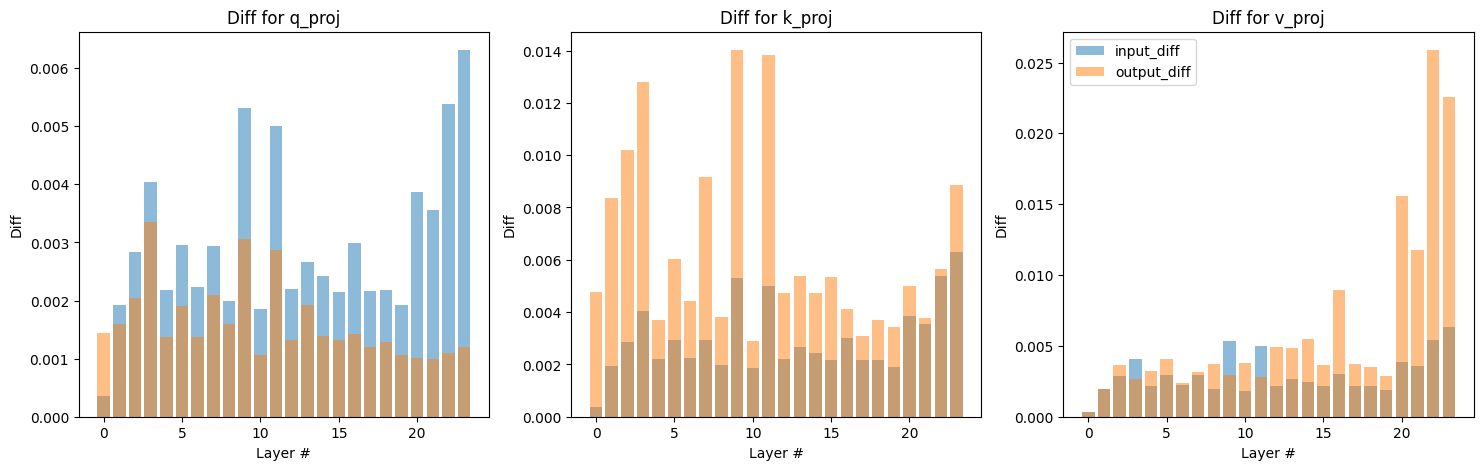

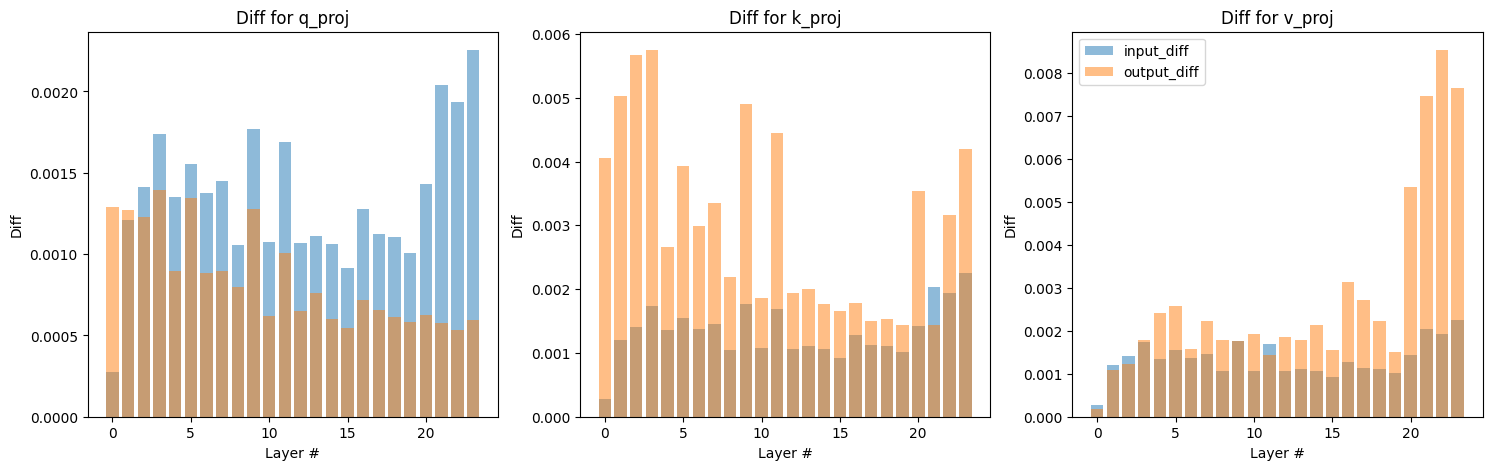

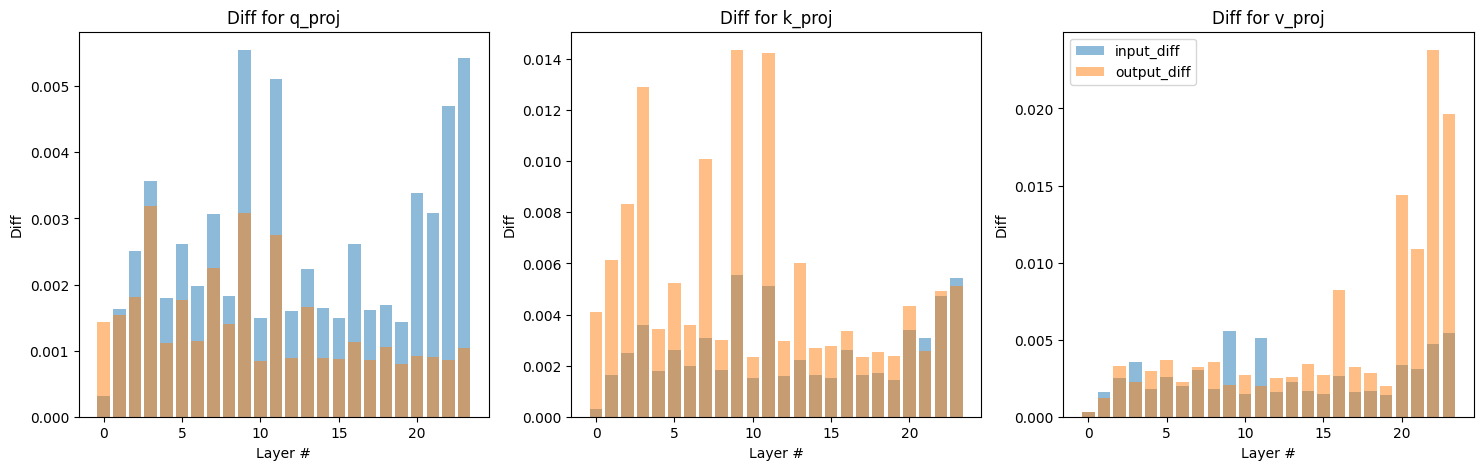

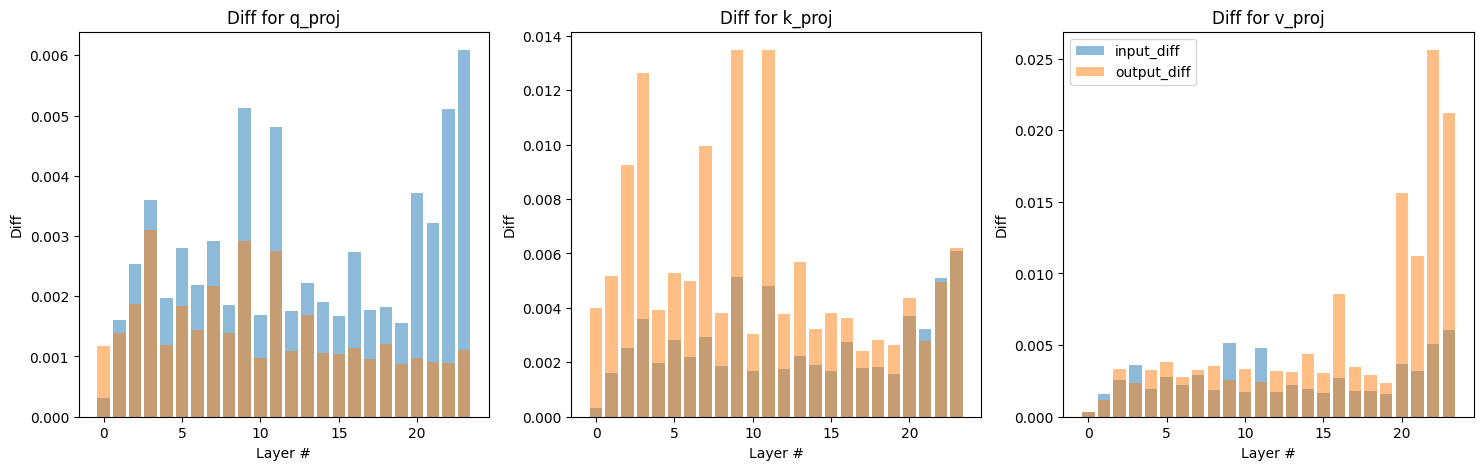

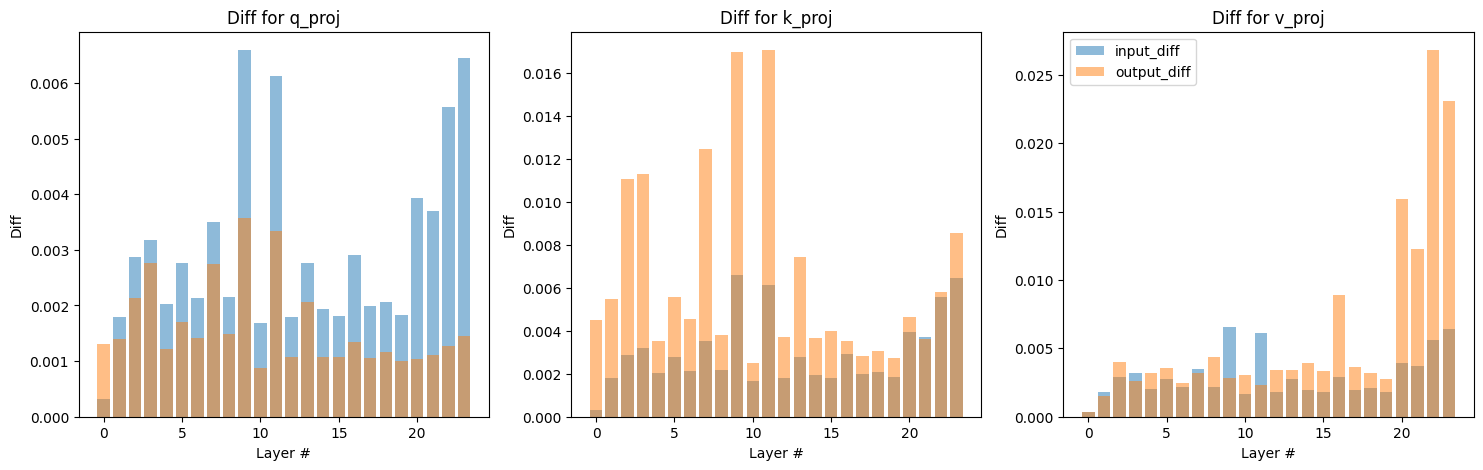

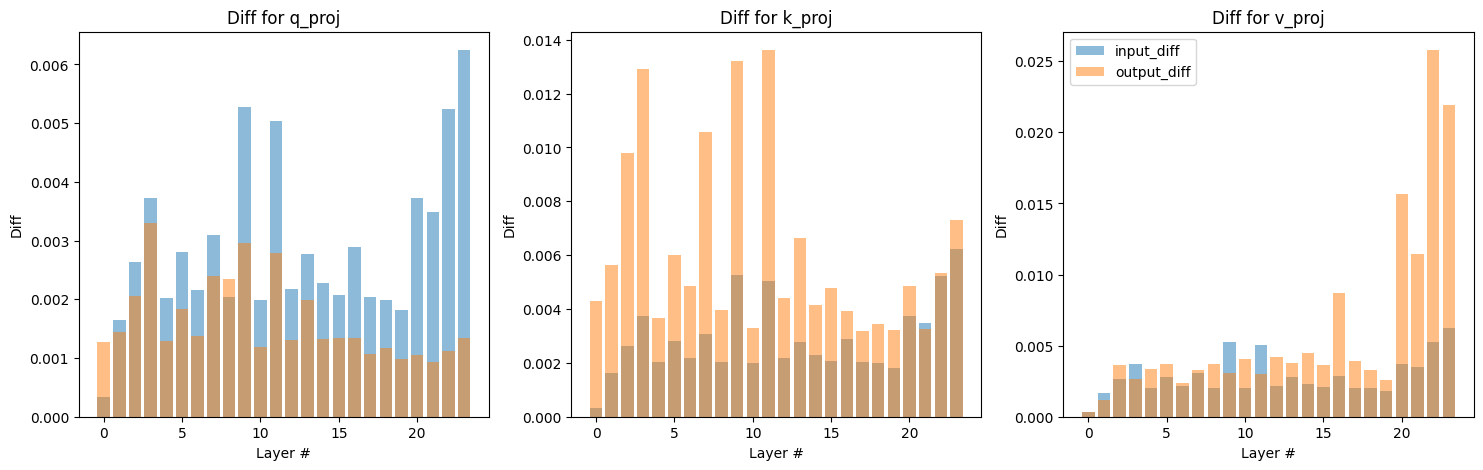

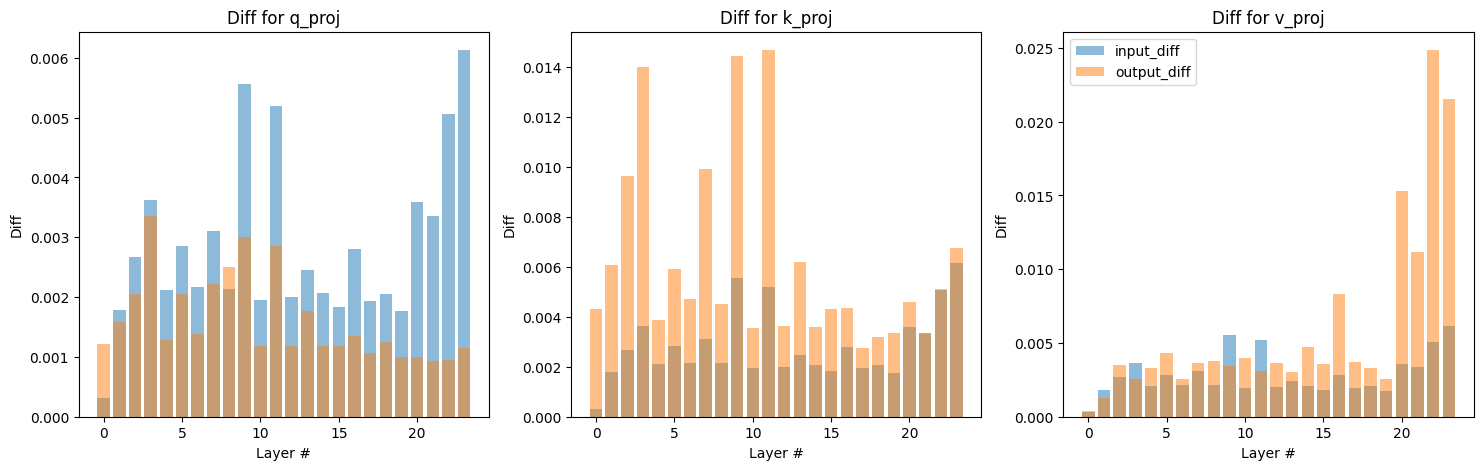

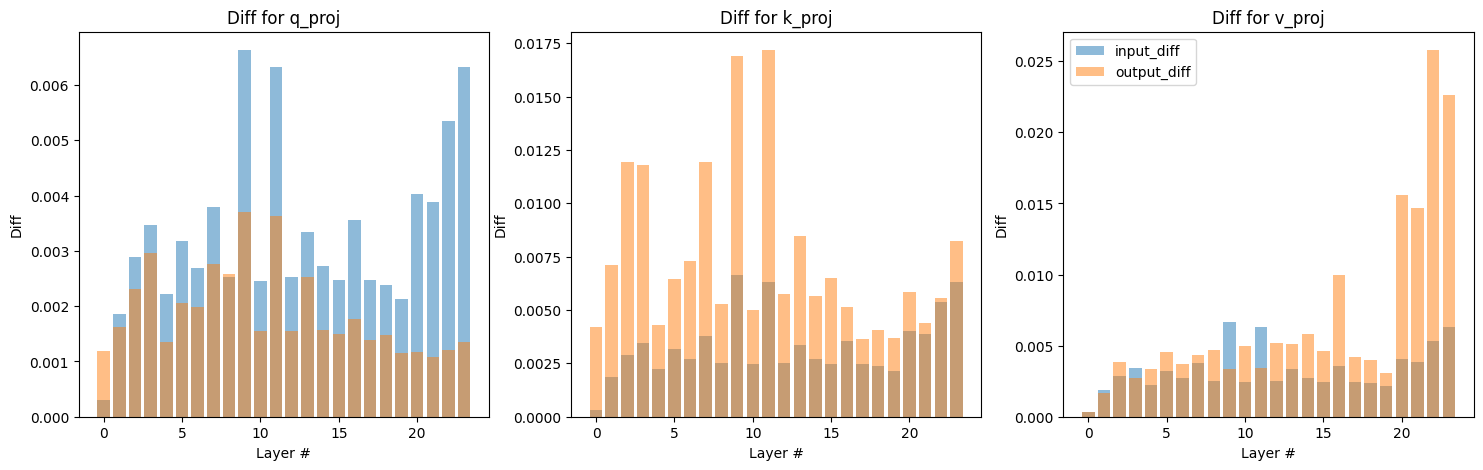

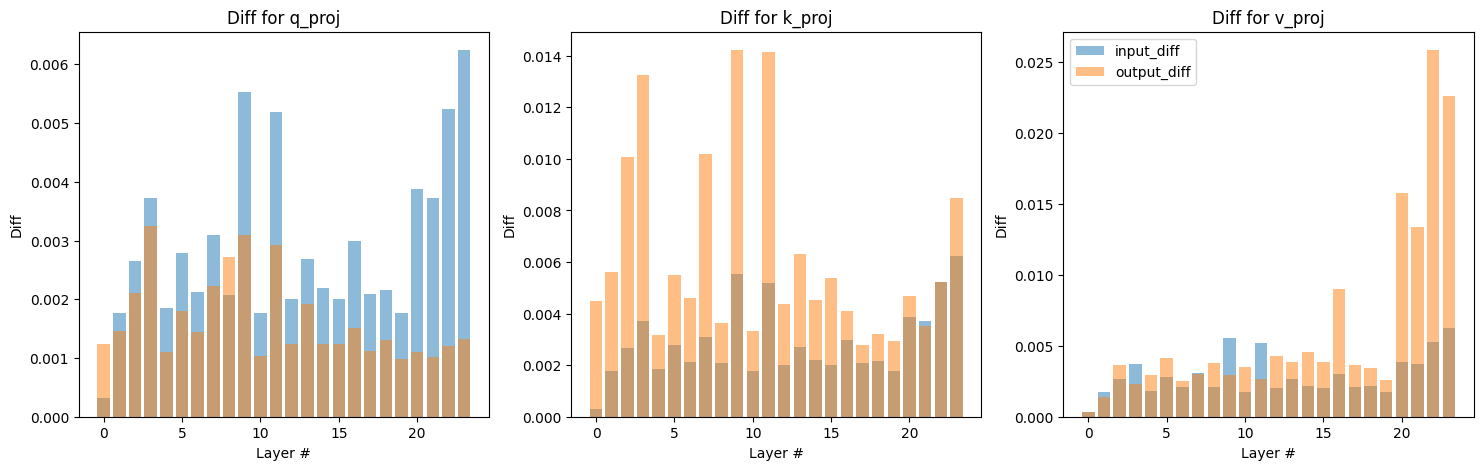

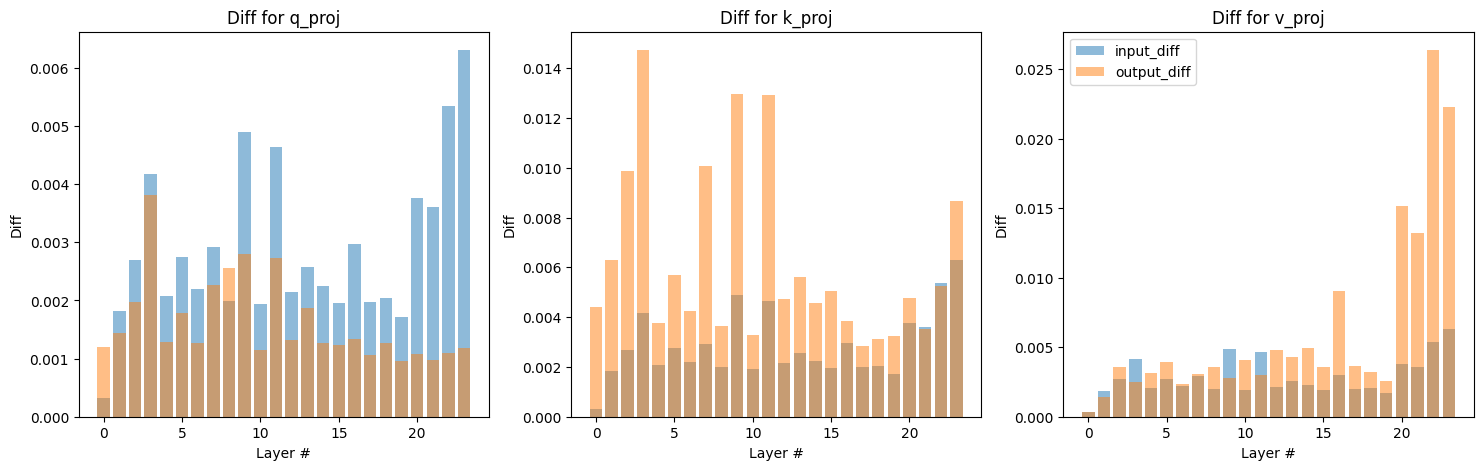

In [200]:
for i in range(52):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_formatter.format(17), 
        hook_data_path_2 = hook_data_path_formatter.format(i),
        forward_hook_module_names = forward_hook_module_names[:],
    )
    # if input(prompts[i]): break